<h1>2021FC04746 | DSECLZG628T | Disseration | Effective Portfolio Construction using Machine Learning and
Optimization Theory

docs


<h2>Libraries Declation

In [5]:
import json, sys, os
module_path = os.path.abspath(os.path.join('..')) # or the path to your source code
sys.path.insert(0, module_path)
import yfinance as yf
import yahoo_fin.stock_info as yfn  
from yahoofinancials import YahooFinancials
import pandas as pd
import numpy as np
from utilities import Helper as hlp

# Plot related libs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
from mlxtend.plotting import plot_decision_regions

#Models related libs
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from keras import layers
from keras import regularizers
from tensorflow.keras.constraints import max_norm
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn import metrics
import math
import warnings
warnings.filterwarnings('ignore')

['c:\\Users\\go4av\\OneDrive\\Desktop\\Dissertation\\Code\\2021fc04746', 'c:\\Users\\go4av\\OneDrive\\Desktop\\Dissertation\\Code\\2021fc04746', 'c:\\Users\\go4av\\OneDrive\\Desktop\\Dissertation\\Code\\2021fc04746\\notebook', 'c:\\Program Files\\Python310\\python310.zip', 'c:\\Program Files\\Python310\\DLLs', 'c:\\Program Files\\Python310\\lib', 'c:\\Program Files\\Python310', '', 'C:\\Users\\go4av\\AppData\\Roaming\\Python\\Python310\\site-packages', 'C:\\Users\\go4av\\AppData\\Roaming\\Python\\Python310\\site-packages\\win32', 'C:\\Users\\go4av\\AppData\\Roaming\\Python\\Python310\\site-packages\\win32\\lib', 'C:\\Users\\go4av\\AppData\\Roaming\\Python\\Python310\\site-packages\\Pythonwin', 'c:\\Program Files\\Python310\\lib\\site-packages', 'C:\\Users\\go4av\\AppData\\Roaming\\Python\\Python310\\site-packages\\IPython\\extensions', 'C:\\Users\\go4av\\.ipython']


<h2>User Interface

<h4>In which sector(s) you want to invest?

In [1]:
industry = [int(x.replace(" ", "")) for x in input("Select choice, multiple choice separated by comma:\n 1.Basic Materials,\n 2.Communication Services, \n3.Consumer Cyclical, 5.Energy, \n6.Financial Services,  7.Healthcare 8.Industrials,  9.Real Estate, 10.Technology, 11.Utilities, 12.Industrial Goods").split(",")]

# Real Estate : 31
# Utilities : 30
# Basic Materials : 22
# Industrial Goods : 1
# 2,9
#2,10,9,6

<h4>What is your investment budget?

In [2]:
investmentBudget = int(input("How much you want to invest?"))

<h4>What should be the timeline of historical data analysis?

In [3]:
dataAnalysisDuration = input("Data Analysis Duration? (Ex: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max)")

<h4>Fetch company data from json

In [6]:
with open("../resources/tickerinfo.json", "r") as jsonFile:
    jsonArray = json.load(jsonFile)

In [3]:
all500Tickers = dict()
path_to_json_files = '../resources/data/'
#get all JSON file names as a list
json_file_names = [filename for filename in os.listdir(path_to_json_files) if filename.endswith('.json')]

for json_file_name in json_file_names:
    with open(os.path.join(path_to_json_files, json_file_name)) as json_file:
        json_text = json.load(json_file)
        all500Tickers.update(json_text)
fTickerDict=all500Tickers

<h4>Get all the sectors and map to ticker

In [5]:
# Create Sector set from company data json
sectorSet = set()
for j in jsonArray:
    for k,v in j.items():
        if v.get('sector')!=None:
            sector = v.get("sector")
            sectorSet.add(sector)

# Map tickers to sector
sectorToTickerDict = dict()
for s in sectorSet:
    tickArr = list()
    for j in jsonArray:
        for k,v in j.items():
            sector = v.get("sector")
            if sector == s:
                tickArr.append(k)
    sectorToTickerDict[s]=tickArr

# Dictionary of sectors
sectorMap = { 1:'Basic Materials',
 2:'Communication Services',
 3:'Consumer Cyclical',
 4:'Consumer Defensive',
 5:'Energy',
 6:'Financial Services',
 7:'Healthcare',
 8:'Industrials',
 9:'Real Estate',
 10:'Technology',
 11:'Utilities',
 12: 'Industrial Goods'}

# Merge all the tickers from sector selections
portfolioTicker = list()
for i in industry:
    portfolioTicker = portfolioTicker+sectorToTickerDict.get(sectorMap.get(i))

<h2>Phase 1: Portfolio Construction

<h3>Build Datasets - Daily Pricing Dataset

<h4>Preparing dataset with Adj Close

In [6]:
priceData = yf.download(portfolioTicker, period=dataAnalysisDuration)['Adj Close']

[*********************100%***********************]  500 of 500 completed


In [25]:
priceData = pd.read_csv('../resources/data/all_500.csv')
priceData = priceData.set_index('Date')

In [5]:
priceData.head()

A        AAL         AAP       AAPL       ABBV        ABC  \
Date                                                                            
2018-08-03  63.364502  37.606430  133.983963  49.692722  76.374176  74.800087   
2018-08-06  64.116425  37.694756  134.372940  49.950756  76.793495  75.880928   
2018-08-07  65.225044  37.547543  134.428513  49.482475  74.419922  77.081879   
2018-08-08  64.955109  37.665310  135.586090  49.515930  74.158836  76.361313   
2018-08-09  64.289948  37.213875  136.864059  49.905365  75.535500  76.897110   

                  ABT       ACGL         ACN        ADBE  ...        WYNN  \
Date                                                      ...               
2018-08-03  60.066799  29.959999  148.779419  253.279999  ...  141.167206   
2018-08-06  60.076000  30.110001  148.974228  254.110001  ...  144.724976   
2018-08-07  59.615570  30.209999  149.549423  253.389999  ...  145.046677   
2018-08-08  59.707664  30.299999  149.493759  253.830002  ...  145.614441   
2018-08-09  59.523495  30.340000  149.029861  253.800003  ...  144.128876   

                  XEL        XOM       XRAY        XYL        YUM         ZBH  \
Date                                                                            
2018-08-03  41.022270  61.909595  45.409702  71.533028  74.892136  117.705933   
2018-08-06  41.109219  61.894146  46.085182  71.598930  74.645119  117.808762   
2018-08-07  41.039658  62.735565  37.494164  72.210709  74.407257  117.266548   
2018-08-08  41.143993  62.318722  38.426521  72.342476  74.947014  115.901688   
2018-08-09  41.422222  62.002228  38.169643  72.182487  75.688080  115.677315   

                  ZBRA       ZION        ZTS  
Date                                          
2018-08-03  142.240005  45.731735  88.662125  
2018-08-06  142.149994  45.637428  89.581360  
2018-08-07  166.619995  45.766029  89.494278  
2018-08-08  157.380005  46.023239  90.210304  
2018-08-09  161.940002  45.568836  89.407204  

[5 rows x 500 columns]

<h3>Build Datasets - Fundamental Dataset

<h4>Method to prepare dataset with Fundamental data

In [597]:
poolSize=len(portfolioTicker)
poolSize=int(poolSize)
if poolSize > 50:
    poolSize=int(poolSize/3)
helpMe = hlp.Helper()
poolSize

166

In [598]:
tickerDict = helpMe.createDictDatasetWithFundamentalDataUsingPool(poolSize=poolSize, tickerArray=portfolioTicker)

Pool size: 166


194. Scraping fundamental data for ---> ALB

194. Scraping fundamental data for ---> APD

194. Scraping fundamental data for ---> CE

194. Scraping fundamental data for ---> CF

194. Scraping fundamental data for ---> CTVA

194. Scraping fundamental data for ---> DD

194. Scraping fundamental data for ---> DOW

194. Scraping fundamental data for ---> ECL

194. Scraping fundamental data for ---> EMN

194. Scraping fundamental data for ---> FCX

194. Scraping fundamental data for ---> FMC

194. Scraping fundamental data for ---> IFF

194. Scraping fundamental data for ---> LIN

194. Scraping fundamental data for ---> LYB

194. Scraping fundamental data for ---> MLM

194. Scraping fundamental data for ---> MOS

194. Scraping fundamental data for ---> NEM

194. Scraping fundamental data for ---> NUE

194. Scraping fundamental data for ---> PPG

194. Scraping fundamental data for ---> SHW

194. Scraping fundamental data for ---> STLD

194. Scraping fundamental data for ---> VMC

194. Scrapi

194. Scrapped fundamental data for ---> BBWI

195. Scraping fundamental data for ---> AIZ

195. Scrapped fundamental data for ---> PPG
195. Scrapped fundamental data for ---> NEM


197. Scrapped fundamental data for ---> LYV

198. Scraping fundamental data for ---> AJG
198. Scraping fundamental data for ---> ALL
198. Scrapped fundamental data for ---> CMCSA

198. Scrapped fundamental data for ---> ECL
198. Scrapped fundamental data for ---> CHTR
198. Scraping fundamental data for ---> AMP
198. Scraping fundamental data for ---> AON



198. Scraping fundamental data for ---> AXP


200. Scraping fundamental data for ---> BAC
200. Scraping fundamental data for ---> BEN


200. Scrapped fundamental data for ---> LYB
200. Scrapped fundamental data for ---> HSY
200. Scraping fundamental data for ---> BK


201. Scraping fundamental data for ---> BLK

201. Scraping fundamental data for ---> BRK-B

201. Scraping fundamental data for ---> BRO

201. Scraping fundamental data for ---> C




203. Sc

245. Scrapped fundamental data for ---> CCL

246. Scraping fundamental data for ---> DXCM

246. Scrapped fundamental data for ---> IPG

247. Scrapped fundamental data for ---> NWS

248. Scrapped fundamental data for ---> YUM



249. Scraping fundamental data for ---> ELV



249. Scrapped fundamental data for ---> TSLA

250. Scrapped fundamental data for ---> NCLH

251. Scraping fundamental data for ---> EW

251. Scraping fundamental data for ---> GEHC

251. Scraping fundamental data for ---> GILD

251. Scraping fundamental data for ---> HCA

251. Scrapped fundamental data for ---> HD

252. Scrapped fundamental data for ---> CMG

253. Scrapped fundamental data for ---> MOS

254. Scraping fundamental data for ---> HOLX

254. Scraping fundamental data for ---> HSIC

254. Scrapped fundamental data for ---> AAP

255. Scrapped fundamental data for ---> MGM

256. Scrapped fundamental data for ---> MDLZ



257. Scrapped fundamental data for ---> APTV



258. Scraping fundamental data for ---> HUM



258. Scraping fundamental data for ---> IDXX

258. Scraping fundamental data for ---> ILMN



258. Scraping fundamental data for ---> INCY

258. Scraping fundamental data for ---> IQV

258. Scraping fundamental data for ---> ISRG

258. Scraping fundamental data for ---> JNJ



258. Scrapped fundamental data for ---> WRK
258. Scrapped fundamental data for ---> RL


260. Scrapped fundamental data for ---> PG

261. Scrapped fundamental data for ---> NVR



262. Scraping fundamental data for ---> LH
262. Scrapped fundamental data for ---> GIS

262. Scrapped fundamental data for ---> MO




264. Scrapped fundamental data for ---> EBAY



265. Scrapped fundamental data for ---> KMX



266. Scrapped fundamental data for ---> AVY

267. Scraping fundamental data for ---> LLY

267. Scraping fundamental data for ---> MCK
267. Scraping fundamental data for ---> MDT


267. Scraping fundamental data for ---> MOH



267. Scrapped fundamental data for ---> WYNN
267. Scrapped fundamental data for ---> LEN


269. Scraping fundamental data for ---> MRK
269. Scraping fundamental data for ---> MRNA


269. Scraping fundamental data for ---> MTD

269. Scraping fundamental data for ---> OGN

269. Scraping fundamental data for ---> PFE

269. Scraping fundamental data for ---> PODD

269. Scraping fundamental data for ---> REGN

269. Scraping fundamental data for ---> RMD

269. Scraping fundamental data for ---> RVTY

269. Scrapped fundamental data for ---> BBY
269. Scrapped fundamental data for ---> SLB


271. Scrapped fundamental data for ---> LVS

272. Scrapped fundamental data for ---> CVX

273. Scrapped fundamental data for ---> EOG

274. Scrapped fundamental data for ---> GPC

275. Scrapped fundamental data for ---> ROST

276. Scrapped fundamental data for ---> CTRA

277. Scrapped fundamental data for ---> KHC

278. Scrapped fundamental data for ---> CLX

279. Scrapped fundamental data for ---> BKNG

28

338. Scraping fundamental data for ---> WM

338. Scraping fundamental data for ---> XYL
338. Scraping fundamental data for ---> AMT


338. Scraping fundamental data for ---> ARE
338. Scraping fundamental data for ---> AVB

338. Scraping fundamental data for ---> BXP


338. Scraping fundamental data for ---> CBRE

338. Scraping fundamental data for ---> CCI

338. Scraping fundamental data for ---> CPT

338. Scraping fundamental data for ---> CSGP

338. Scraping fundamental data for ---> DLR

338. Scraping fundamental data for ---> EQIX

338. Scraping fundamental data for ---> EQR

338. Scrapped fundamental data for ---> FDS

339. Scrapped fundamental data for ---> HBAN

340. Scrapped fundamental data for ---> CMA

341. Scrapped fundamental data for ---> AMGN

342. Scrapped fundamental data for ---> MTB

343. Scraping fundamental data for ---> ESS

343. Scrapped fundamental data for ---> MA

344. Scrapped fundamental data for ---> HIG

345. Scrapped fundamental data for ---> BLK

346. Sc

360. Scrapped fundamental data for ---> BK



361. Scraping fundamental data for ---> EXR

361. Scraping fundamental data for ---> FRT

361. Scraping fundamental data for ---> HST

361. Scraping fundamental data for ---> INVH

361. Scraping fundamental data for ---> IRM

361. Scraping fundamental data for ---> KIM

361. Scraping fundamental data for ---> MAA

361. Scraping fundamental data for ---> O

361. Scraping fundamental data for ---> PEAK

361. Scraping fundamental data for ---> PLD

361. Scraping fundamental data for ---> PSA

361. Scraping fundamental data for ---> REG

361. Scraping fundamental data for ---> SBAC

361. Scraping fundamental data for ---> SPG

361. Scraping fundamental data for ---> UDR

361. Scraping fundamental data for ---> VICI

361. Scraping fundamental data for ---> VTR

361. Scraping fundamental data for ---> WELL

361. Scrapped fundamental data for ---> ALL



362. Scrapped fundamental data for ---> PRU

363. Scraping fundamental data for ---> WY

363. Scraping fundamental data for ---> AAPL

363. Scrapped fundamental data for ---> DFS

364. Scrapped fundamental data for ---> CINF

365. Scraping fundamental data for ---> ACN

365. Scraping fundamental data for ---> ADBE

365. Scrapped fundamental data for ---> CME

366. Scraping fundamental data for ---> ADI



366. Scrapped fundamental data for ---> RJF

367. Scraping fundamental data for ---> ADSK

367. Scraping fundamental data for ---> AKAM

367. Scraping fundamental data for ---> AMAT

367. Scraping fundamental data for ---> AMD

367. Scraping fundamental data for ---> ANET



367. Scraping fundamental data for ---> ANSS

367. Scrapped fundamental data for ---> PFG

368. Scrapped fundamental data for ---> NDAQ



369. Scraping fundamental data for ---> APH

369. Scrapped fundamental data for ---> TRV

370. Scraping fundamental data for ---> AVGO

370. Scraping fundamental data for ---> BR

370. Scrapped fundamental data for ---> BRK-B



371. Scraping fundamental data for ---> CDAY

371. Scrapped fundamental data for ---> WTW

372. Scrapped fundamental data for ---> C

373. Scrapped fundamental data for ---> DVA

374. Scrapped fundamental data for ---> HUM

375. Scrapped fundamental data for ---> WRB

376. Scrapped fundamental data for ---> BDX
376. Scrapped fundamental data for ---> HCA


378. Scrapped fundamental data for ---> ELV

379. Scrapped fundamental data for ---> ABC

380. Scrapped fundamental data for ---> A

381. Scrapped fundamental data for ---> COO

382. Scraping fundamental data for ---> CDNS

382. Scraping fundamental data for ---> CRM
382. Scraping fundamental data for ---> CDW


382. Scraping fundamental data for ---> CSCO
382. Scraping fundamental data for ---> CTSH

382. Scraping fundamental data for ---> DXC
382. Scraping fundamental data for ---> ENPH

382. Scraping fundamental data for ---> EPAM
382. Scraping fundamental data for ---> FFIV
382. Scraping fundamental data for ---> FI



382. Scrap

491. Scrapped fundamental data for ---> LH

492. Scrapped fundamental data for ---> NVDA

493. Scrapped fundamental data for ---> QRVO

494. Scrapped fundamental data for ---> STX

495. Scrapped fundamental data for ---> PAYX

496. Scrapped fundamental data for ---> AES

497. Scrapped fundamental data for ---> ROP

498. Scrapped fundamental data for ---> AWK

499. Scrapped fundamental data for ---> PNW

500. Scrapped fundamental data for ---> TDG

501. Scrapped fundamental data for ---> CMS

502. Scrapped fundamental data for ---> RSG
502. Scrapped fundamental data for ---> TXT
502. Scrapped fundamental data for ---> MCHP



505. Scrapped fundamental data for ---> PNR

506. Scrapped fundamental data for ---> ATO
506. Scrapped fundamental data for ---> FFIV
506. Scrapped fundamental data for ---> CSCO



509. Scrapped fundamental data for ---> GRMN

510. Scrapped fundamental data for ---> FSLR

511. Scrapped fundamental data for ---> TER
511. Scrapped fundamental data for ---> UNP
511. 

In [11]:
tickerie = list()
fTickerDict = dict()
#
for r in tickerDict:
    print(r)
    tickerie.append(r)



{'ATVI': {'Market Cap (intraday)': '72.30B', 'Enterprise Value': '62.83B', 'Trailing P/E': '33.66', 'Forward P/E': '23.36', 'PEG Ratio (5 yr expected)': '2.32', 'Price/Sales (ttm)': '8.36', 'Price/Book (mrq)': '3.48', 'Enterprise Value/Revenue': '7.22', 'Enterprise Value/EBITDA': '20.45', 'Beta (5Y Monthly)': 'N/A', '52-Week Change 3': '1,402.16%', 'S&P500 52-Week Change 3': '1,014.54%', '52 Week High 3': '93.67', '52 Week Low 3': '70.94', '50-Day Moving Average 3': '84.58', '200-Day Moving Average 3': '79.02', 'Avg Vol (3 month) 3': '10.92M', 'Avg Vol (10 day) 3': '12.47M', 'Shares Outstanding 5': '786.16M', 'Implied Shares Outstanding 6': 'N/A', 'Float 8': 'N/A', '% Held by Insiders 1': '0.84%', '% Held by Institutions 1': '81.17%', 'Shares Short (Jul 13, 2023) 4': '12.12M', 'Short Ratio (Jul 13, 2023) 4': '0.84', 'Short % of Float (Jul 13, 2023) 4': '1.55%', 'Short % of Shares Outstanding (Jul 13, 2023) 4': '1.54%', 'Shares Short (prior month Jun 14, 2023) 4': '18.94M', 'Forward Ann

In [12]:
#
for r in tickerie:
    fTickerDict.update(r)

In [57]:
# with open("150tickerdict.json", "r") as jsonFile:
#     fTickerDict = json.load(jsonFile)

In [67]:
fIndex = [k for k, v in fTickerDict.items()]
fColSet = set()
for k,v in fTickerDict.items():
    for k1, v1 in v.items():
        fColSet.add(k1)
fColList = list(fColSet)

fDframe = pd.DataFrame(index=fIndex, columns=fColList)
for k,v in fTickerDict.items():
    for index in fDframe.index:
        if index == k:
            for feature, itsValue in v.items():
                fDframe.loc[index, feature] = itsValue
fDframe.head()

Implied Shares Outstanding 6 Profit Margin  \
APA                           N/A        19.89%   
BKR                            7M         4.94%   
COP                           N/A        20.39%   
CTRA                          N/A        45.50%   
CVX                           N/A        14.08%   

     Short % of Float (Jul 13, 2023) 4 Revenue (ttm)  \
APA                              3.93%        10.22B   
BKR                              2.58%         23.3B   
COP                              0.77%         77.7B   
CTRA                             5.31%         9.09B   
CVX                              1.06%       214.19B   

     PEG Ratio (5 yr expected) Levered Free Cash Flow (ttm) Price/Sales (ttm)  \
APA                        N/A                        2.67B              1.25   
BKR                        N/A                        1.97B              1.55   
COP                       0.72                       15.99B              1.95   
CTRA                       N/A                        2.75B              2.38   
CVX                        N/A                          N/A              1.45   

     Avg Vol (10 day) 3 Enterprise Value/EBITDA Avg Vol (3 month) 3  ...  \
APA               4.23M                    3.12               5.32M  ...   
BKR               8.94M                   12.61               7.48M  ...   
COP                4.3M                    4.47               5.55M  ...   
CTRA              5.31M                    3.21               7.04M  ...   
CVX               7.78M                    6.01               7.62M  ...   

     Current Ratio (mrq) S&P500 52-Week Change 3 Total Cash (mrq)  \
APA                 1.11                 870.56%             154M   
BKR                 1.28                   8.71%            3.85B   
COP                 1.39                 870.56%            8.61B   
CTRA                1.66                   8.71%             973M   
CVX                  N/A                 870.56%            15.8B   

     Shares Short (prior month Jun 14, 2023) 4 % Held by Institutions 1  \
APA                                      9.69M                   82.62%   
BKR                                     16.46M                   97.79%   
COP                                      9.93M                   81.60%   
CTRA                                    32.96M                   95.84%   
CVX                                     18.83M                   72.58%   

     200-Day Moving Average 3 Quarterly Earnings Growth (yoy)  \
APA                     39.67                         -87.10%   
BKR                     29.86                             N/A   
COP                    110.97                         -49.30%   
CTRA                    25.62                          11.30%   
CVX                    166.87                         -48.30%   

     Beta (5Y Monthly) Enterprise Value Shares Short 4  
APA               3.52           18.21B            NaN  
BKR               1.51           39.95B            NaN  
COP               1.32          150.01B            NaN  
CTRA              0.28           22.51B            NaN  
CVX               1.16          310.82B            NaN  

[5 rows x 70 columns]

In [68]:
fDframe.shape

(500, 70)

<h4>Storing in local files

In [14]:
import json
with open(f"../resources/{priceData.shape[1]}_ticker.json", "w") as outfile:
    outfile.write(json.dumps(fTickerDict, indent=4))
    
priceData.to_csv(f"../resources/{priceData.shape[1]}_dataset.csv")

In [8]:
len(fTickerDict)

500

<h3>Exploratory Data Analysis - Daily Pricing Dataset

<h4>Size of the dataset

In [26]:
priceData.shape

(1258, 500)

<h4>Describing the dataset

In [27]:
priceData.describe()

A          AAL          AAP         AAPL         ABBV  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean    108.814952    21.078886   155.788681   110.950160   101.002338   
std      32.115494     8.056101    33.694609    47.101297    32.640022   
min      59.054771     9.040000    63.355339    34.209969    52.443924   
25%      75.659931    14.255000   140.202915    59.294083    72.889826   
50%     116.736786    18.500000   149.807907   124.210972    95.568104   
75%     134.091007    28.055047   178.957382   149.184593   135.366806   
max     177.025681    42.788101   229.554703   196.449997   165.176773   

               ABC          ABT         ACGL          ACN         ADBE  ...  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000  ...   
mean    112.639308    96.308936    42.031383   240.058743   398.125263  ...   
std      33.212114    19.206603    12.818544    64.871778   116.511133  ...   
min      65.951378    58.409275    22.240000   125.142578   205.160004  ...   
25%      82.599922    78.912762    32.352499   179.362484   293.634987  ...   
50%     102.778736   101.690628    39.980001   248.202400   377.554993  ...   
75%     140.781162   111.571791    46.137500   287.728218   479.717499  ...   
max     193.410004   137.151871    82.269997   405.092682   688.369995  ...   

              WYNN          XEL          XOM         XRAY          XYL  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean     99.687547    60.174502    65.709875    45.895071    89.492590   
std      23.136269     8.091865    23.718595     9.699495    19.130994   
min      42.922478    40.372875    26.335976    26.528397    54.479130   
25%      81.769213    55.669967    51.505032    37.454523    74.143612   
50%     103.055389    62.182844    59.508947    46.066084    84.990074   
75%     116.611725    65.908289    82.752138    54.123201   104.459227   
max     150.601212    75.150078   117.321945    67.274055   135.091400   

               YUM          ZBH         ZBRA         ZION          ZTS  
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000  
mean    105.740933   126.561792   315.199666    43.952777   147.958568  
std      17.764254    16.351475   125.997400    10.797809    37.066674  
min      53.255268    76.251190   142.149994    19.586090    76.817032  
25%      91.531164   114.729403   211.549999    36.692516   120.756195  
50%     105.466682   125.467167   277.859985    44.217226   155.137604  
75%     120.162460   139.330147   394.099991    51.458944   171.583210  
max     142.236282   170.515839   614.549988    70.517998   243.595840  

[8 rows x 500 columns]

<h4>Information on dataset

In [11]:
priceData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 2018-08-03 to 2023-08-03
Columns: 500 entries, A to ZTS
dtypes: float64(500)
memory usage: 4.8+ MB


<h4>Check for missing data

In [12]:
priceData.isnull().sum()

A       0
AAL     0
AAP     0
AAPL    0
ABBV    0
       ..
YUM     0
ZBH     0
ZBRA    0
ZION    0
ZTS     0
Length: 500, dtype: int64

In [13]:
priceData.isna().sum()

A       0
AAL     0
AAP     0
AAPL    0
ABBV    0
       ..
YUM     0
ZBH     0
ZBRA    0
ZION    0
ZTS     0
Length: 500, dtype: int64

<h4>Check for duplicate values

In [14]:
priceData.duplicated().sum()

0

<h4>Correlation Table

In [28]:
pearsoncorr = priceData.corr(method='pearson')

pearsoncorr

A       AAL       AAP      AAPL      ABBV       ABC       ABT  \
A     1.000000 -0.583896  0.481102  0.891499  0.794423  0.760426  0.911919   
AAL  -0.583896  1.000000  0.044994 -0.703049 -0.601914 -0.591811 -0.658860   
AAP   0.481102  0.044994  1.000000  0.283728  0.224576  0.067180  0.476650   
AAPL  0.891499 -0.703049  0.283728  1.000000  0.879059  0.887173  0.897828   
ABBV  0.794423 -0.601914  0.224576  0.879059  1.000000  0.953345  0.695829   
...        ...       ...       ...       ...       ...       ...       ...   
YUM   0.816897 -0.382219  0.260231  0.810174  0.779896  0.829690  0.746041   
ZBH   0.382474 -0.073528  0.090894  0.312438  0.057237  0.124822  0.465698   
ZBRA  0.808325 -0.347312  0.663130  0.674220  0.404932  0.361798  0.864864   
ZION  0.550633  0.078852  0.844000  0.387914  0.398649  0.277054  0.496854   
ZTS   0.889505 -0.646863  0.471253  0.895647  0.671408  0.661719  0.952759   

          ACGL       ACN      ADBE  ...      WYNN       XEL       XOM  \
A     0.555118  0.928708  0.741135  ... -0.302090  0.748180  0.425190   
AAL  -0.357009 -0.567530 -0.484749  ...  0.697953 -0.778861 -0.154922   
AAP  -0.178528  0.503611  0.438132  ... -0.159203  0.231647 -0.039312   
AAPL  0.670810  0.936974  0.691216  ... -0.412894  0.813162  0.500678   
ABBV  0.769704  0.782499  0.339400  ... -0.429552  0.734195  0.772544   
...        ...       ...       ...  ...       ...       ...       ...   
YUM   0.830078  0.840035  0.497371  ... -0.106147  0.685490  0.675987   
ZBH   0.193413  0.349997  0.563019  ...  0.464522  0.319285 -0.162870   
ZBRA  0.144077  0.823985  0.899570  ... -0.084427  0.521883 -0.056058   
ZION  0.093222  0.582306  0.356307  ... -0.054537  0.257076  0.235933   
ZTS   0.466945  0.951153  0.868433  ... -0.351254  0.794632  0.205018   

          XRAY       XYL       YUM       ZBH      ZBRA      ZION       ZTS  
A     0.151090  0.897349  0.816897  0.382474  0.808325  0.550633  0.889505  
AAL   0.203913 -0.345635 -0.382219 -0.073528 -0.347312  0.078852 -0.646863  
AAP   0.362315  0.384101  0.260231  0.090894  0.663130  0.844000  0.471253  
AAPL -0.011135  0.758375  0.810174  0.312438  0.674220  0.387914  0.895647  
ABBV -0.297821  0.582360  0.779896  0.057237  0.404932  0.398649  0.671408  
...        ...       ...       ...       ...       ...       ...       ...  
YUM   0.119740  0.809497  1.000000  0.346677  0.564328  0.414797  0.757097  
ZBH   0.694818  0.558537  0.346677  1.000000  0.550098  0.111857  0.429047  
ZBRA  0.583894  0.798910  0.564328  0.550098  1.000000  0.626919  0.857525  
ZION  0.290628  0.466217  0.414797  0.111857  0.626919  1.000000  0.464115  
ZTS   0.305581  0.799245  0.757097  0.429047  0.857525  0.464115  1.000000  

[500 rows x 500 columns]

<h3>Exploratory Data Analysis - Fundamental Dataset

<h4>Size of the dataset

In [16]:
fDframe.shape

(500, 70)

<h4>Describing the dataset

In [17]:
fDframe.describe()

Implied Shares Outstanding 6 Profit Margin  \
count                           500           500   
unique                           11           403   
top                             N/A           N/A   
freq                            490            79   

       Short % of Float (Jul 13, 2023) 4 Revenue (ttm)  \
count                                420           500   
unique                               285           392   
top                                1.29%           N/A   
freq                                   6            79   

       PEG Ratio (5 yr expected) Levered Free Cash Flow (ttm)  \
count                        500                          500   
unique                       281                          342   
top                          N/A                          N/A   
freq                          86                          136   

       Price/Sales (ttm) Avg Vol (10 day) 3 Enterprise Value/EBITDA  \
count                500                500                     500   
unique               365                401                     407   
top                 1.25              2.18M                     N/A   
freq                   4                  5                      47   

       Avg Vol (3 month) 3  ... Current Ratio (mrq) S&P500 52-Week Change 3  \
count                  500  ...                 500                     500   
unique                 403  ...                 214                       3   
top                  1.66M  ...                 N/A                 870.56%   
freq                     5  ...                 117                     382   

       Total Cash (mrq) Shares Short (prior month Jun 14, 2023) 4  \
count               500                                       420   
unique              384                                       380   
top                 N/A                                     4.16M   
freq                 82                                         3   

       % Held by Institutions 1 200-Day Moving Average 3  \
count                       500                      500   
unique                      399                      491   
top                         N/A                    83.38   
freq                         79                        2   

       Quarterly Earnings Growth (yoy) Beta (5Y Monthly) Enterprise Value  \
count                              500               500              500   
unique                             344               150              459   
top                                N/A               N/A              N/A   
freq                               125               109               26   

       Shares Short 4  
count              79  
unique              1  
top               N/A  
freq               79  

[4 rows x 70 columns]

<h4>Information on dataset

In [18]:
fDframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, APA to ZBRA
Data columns (total 70 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   Implied Shares Outstanding 6                    500 non-null    object
 1   Profit Margin                                   500 non-null    object
 2   Short % of Float (Jul 13, 2023) 4               420 non-null    object
 3   Revenue (ttm)                                   500 non-null    object
 4   PEG Ratio (5 yr expected)                       500 non-null    object
 5   Levered Free Cash Flow (ttm)                    500 non-null    object
 6   Price/Sales (ttm)                               500 non-null    object
 7   Avg Vol (10 day) 3                              500 non-null    object
 8   Enterprise Value/EBITDA                         500 non-null    object
 9   Avg Vol (3 month) 3                             500 non-

<h4>Check for missing data

In [19]:
fDframe.isnull().sum()

Implied Shares Outstanding 6           0
Profit Margin                          0
Short % of Float (Jul 13, 2023) 4     80
Revenue (ttm)                          0
PEG Ratio (5 yr expected)              0
                                    ... 
200-Day Moving Average 3               0
Quarterly Earnings Growth (yoy)        0
Beta (5Y Monthly)                      0
Enterprise Value                       0
Shares Short 4                       421
Length: 70, dtype: int64

In [20]:
fDframe.isna().sum()

Implied Shares Outstanding 6           0
Profit Margin                          0
Short % of Float (Jul 13, 2023) 4     80
Revenue (ttm)                          0
PEG Ratio (5 yr expected)              0
                                    ... 
200-Day Moving Average 3               0
Quarterly Earnings Growth (yoy)        0
Beta (5Y Monthly)                      0
Enterprise Value                       0
Shares Short 4                       421
Length: 70, dtype: int64

<h4>Check for duplicate values

In [56]:
fDframe.duplicated().sum()

0

<h3>Data Warnagling Level 1 - Daily Pricing Dataset

<h4>Check empty ticker and drop them

In [29]:
#Collect no data ticker
emptyColDropList = list()
for ticker in priceData:
    if priceData[ticker].isna().sum()>0:
        emptyColDropList.append(ticker)
        

emptyColDropList

['CARR',
 'CEG',
 'CTVA',
 'DOW',
 'FOX',
 'FOXA',
 'GEHC',
 'MRNA',
 'OGN',
 'OTIS',
 'ROP']

In [30]:
if len(emptyColDropList) > 0:
    priceData=priceData.drop(emptyColDropList, axis=1)
    print(f"Dropped following columns from the dataframe: {emptyColDropList}")

Dropped following columns from the dataframe: ['CARR', 'CEG', 'CTVA', 'DOW', 'FOX', 'FOXA', 'GEHC', 'MRNA', 'OGN', 'OTIS', 'ROP']


In [31]:
priceData.shape

(1258, 489)

<h4>Fill any missing value by previous available data

In [33]:
priceData=priceData.ffill()
priceData.head()

A        AAL         AAP       AAPL       ABBV        ABC  \
Date                                                                            
2018-08-03  63.364502  37.606430  133.983963  49.692722  76.374176  74.800087   
2018-08-06  64.116425  37.694756  134.372940  49.950756  76.793495  75.880928   
2018-08-07  65.225044  37.547543  134.428513  49.482475  74.419922  77.081879   
2018-08-08  64.955109  37.665310  135.586090  49.515930  74.158836  76.361313   
2018-08-09  64.289948  37.213875  136.864059  49.905365  75.535500  76.897110   

                  ABT       ACGL         ACN        ADBE  ...        WYNN  \
Date                                                      ...               
2018-08-03  60.066799  29.959999  148.779419  253.279999  ...  141.167206   
2018-08-06  60.076000  30.110001  148.974228  254.110001  ...  144.724976   
2018-08-07  59.615570  30.209999  149.549423  253.389999  ...  145.046677   
2018-08-08  59.707664  30.299999  149.493759  253.830002  ...  145.614441   
2018-08-09  59.523495  30.340000  149.029861  253.800003  ...  144.128876   

                  XEL        XOM       XRAY        XYL        YUM         ZBH  \
Date                                                                            
2018-08-03  41.022270  61.909595  45.409702  71.533028  74.892136  117.705933   
2018-08-06  41.109219  61.894146  46.085182  71.598930  74.645119  117.808762   
2018-08-07  41.039658  62.735565  37.494164  72.210709  74.407257  117.266548   
2018-08-08  41.143993  62.318722  38.426521  72.342476  74.947014  115.901688   
2018-08-09  41.422222  62.002228  38.169643  72.182487  75.688080  115.677315   

                  ZBRA       ZION        ZTS  
Date                                          
2018-08-03  142.240005  45.731735  88.662125  
2018-08-06  142.149994  45.637428  89.581360  
2018-08-07  166.619995  45.766029  89.494278  
2018-08-08  157.380005  46.023239  90.210304  
2018-08-09  161.940002  45.568836  89.407204  

[5 rows x 489 columns]

<h4>To be pull from Helper

In [34]:
def StockReturnsComputing(StockPrice, Rows, Columns):    
    StockReturn = np.zeros([Rows-1, Columns])
    for j in range(Columns):        # j: Assets
        for i in range(Rows-1):     # i: Daily Prices
            StockReturn[i,j]=((StockPrice.iloc[i+1, j]-StockPrice.iloc[i,j])/StockPrice.iloc[i,j])* 100

    return StockReturn

<h4>Get Daily return

In [35]:
dailyReturn = np.array(StockReturnsComputing(StockPrice=priceData, Rows=priceData.shape[0], Columns=priceData.shape[1]))
dailyReturn

array([[  1.18666222,   0.23486808,   0.29031613, ...,  -0.06328149,
         -0.20621773,   1.03678457],
       [  1.72907285,  -0.39053969,   0.04135692, ...,  17.21421194,
          0.28178861,  -0.09720985],
       [ -0.4138527 ,   0.31364858,   0.86111011, ...,  -5.54554706,
          0.56201025,   0.80008054],
       ...,
       [  0.58307197,  -3.10448034,  -0.90065624, ..., -17.27171992,
         -3.00653994,  -1.37168477],
       [  4.27008131,  -1.72519865,  -5.53445709, ...,  -5.34600233,
         -1.26683942,  -1.89207838],
       [ -1.42510352,  -0.84639643,   0.50258253, ...,   0.86253447,
          0.10919219,   0.17038702]])

In [36]:
dailyReturn.shape

(1257, 489)

<h4>Calculate Mean Return & Covariance Return on Daily pricing data

In [37]:
#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(dailyReturn, axis = 0)
print('Mean returns:\n', meanReturns)
covReturns = np.cov(dailyReturn, rowvar=False)
#set precision for printing results
np.set_printoptions(precision=5, suppress = True)
print('Size of Variance-Covariance matrix of returns:\n', covReturns.shape)
print('Variance-Covariance matrix of returns:\n', covReturns)

Mean returns:
 [ 0.07190239  0.00558408 -0.02146029  0.12951961  0.06691896  0.09131101
  0.06059897  0.09681437  0.07581389  0.08707418  0.08652985  0.06862683
  0.07250984  0.06817737  0.04589027  0.03662724  0.07185319  0.06957855
  0.0553337   0.04768317  0.10917009  0.03496129  0.11505419  0.06164967
  0.023553    0.03458968  0.04831672  0.135019    0.02560978  0.20830211
  0.07617916  0.03649368  0.11325329  0.04168347  0.05371598  0.11999982
  0.07029732  0.08187517  0.04217833  0.11153997  0.07088289  0.06931479
  0.05506595  0.0235259   0.04296724  0.04650728  0.03157178  0.15311063
  0.06607079  0.05954622  0.12692291  0.07320068  0.11439097  0.02168882
  0.0338969   0.05372385 -0.01807158  0.11354143  0.04927141  0.02756106
  0.03297283  0.04060843  0.0792268   0.02671012  0.04413579  0.01969322
  0.0533679   0.05875148  0.06179654  0.02598316  0.05042957  0.0548286
  0.08751242  0.05076962  0.03910237 -0.0109926   0.00762957  0.01891038
  0.08269392  0.05503924  0.04739303 

In [38]:
#prepare asset parameters for k-means clustering
#reshape for concatenation
meanReturns = meanReturns.reshape(len(meanReturns),1)
assetParameters = np.concatenate([meanReturns, covReturns], axis = 1)
print('Size of the asset parameters for clustering:\n', assetParameters.shape)
print('Asset parameters for clustering:\n', assetParameters)

Size of the asset parameters for clustering:
 (489, 490)
Asset parameters for clustering:
 [[ 0.0719   3.45136  2.26172 ...  2.72355  1.87606  2.09436]
 [ 0.00558  2.26172 15.28806 ...  3.60476  5.22913  1.77419]
 [-0.02146  1.5508   2.84597 ...  2.24537  2.59538  1.55726]
 ...
 [ 0.07834  2.72355  3.60476 ...  7.09827  3.02882  2.45091]
 [ 0.02339  1.87606  5.22913 ...  3.02882  8.16067  1.33186]
 [ 0.07331  2.09436  1.77419 ...  2.45091  1.33186  3.1801 ]]


<h3>Data Warnagling Level 2 - Fundamental Dataset

<h4>Drop tickers from Fundamental dataset

In [140]:
# for ticker in emptyColDropList:
#     del fTickerDict[ticker]
#     print(f"Dropped {ticker} ticker from fundamental data dictionary")

In [69]:
fDframe = fDframe.drop(emptyColDropList)
fDframe.shape

(489, 70)

<h4>Customize fundamental dataset with required features

In [70]:
fDframe = fDframe[['Price/Book (mrq)', 'Operating Cash Flow (ttm)', 'Operating Margin (ttm)', 'Revenue Per Share (ttm)', 'Enterprise Value/Revenue', 'Gross Profit (ttm)', 'PEG Ratio (5 yr expected)',
                 'Current Ratio (mrq)', 'Enterprise Value', '50-Day Moving Average 3', 'Diluted EPS (ttm)', 'Revenue (ttm)',
                 'Enterprise Value/EBITDA', 'Total Cash Per Share (mrq)', 'EBITDA', 'Beta (5Y Monthly)', 'Market Cap (intraday)',
                 'Forward Annual Dividend Rate 4', 'Book Value Per Share (mrq)', 'Price/Sales (ttm)', 'Return on Assets (ttm)', 'Profit Margin',
                 'Quarterly Revenue Growth (yoy)', 'Forward P/E', 'Float 8', '200-Day Moving Average 3',]]


In [71]:
fDframe.columns=fDframe.columns.str.replace(" ","_")
fDframe.head()

Price/Book_(mrq) Operating_Cash_Flow_(ttm) Operating_Margin_(ttm)  \
APA             27.97                     4.39B                 46.21%   
BKR              2.39                     2.82B                  9.82%   
COP              2.97                    28.65B                 32.07%   
CTRA             1.65                     5.63B                 58.66%   
CVX              1.92                     41.3B                 16.81%   

     Revenue_Per_Share_(ttm) Enterprise_Value/Revenue Gross_Profit_(ttm)  \
APA                    31.62                     1.75              7.64B   
BKR                    23.14                     1.71              4.43B   
COP                    61.98                     1.99              39.6B   
CTRA                   11.58                     2.46              7.64B   
CVX                   112.74                     1.45             98.89B   

     PEG_Ratio_(5_yr_expected) Current_Ratio_(mrq) Enterprise_Value  \
APA                        N/A                1.11           18.21B   
BKR                        N/A                1.28           39.95B   
COP                       0.72                1.39          150.01B   
CTRA                       N/A                1.66           22.51B   
CVX                        N/A                 N/A          310.82B   

     50-Day_Moving_Average_3  ... Market_Cap_(intraday)  \
APA                    35.31  ...                12.42B   
BKR                    31.80  ...                36.12B   
COP                   106.04  ...               142.04B   
CTRA                   25.31  ...                20.91B   
CVX                   156.51  ...               303.41B   

     Forward_Annual_Dividend_Rate_4 Book_Value_Per_Share_(mrq)  \
APA                               1                       1.44   
BKR                             0.8                      14.99   
COP                             2.4                      39.49   
CTRA                            2.1                      16.70   
CVX                            6.04                      84.18   

     Price/Sales_(ttm) Return_on_Assets_(ttm) Profit_Margin  \
APA               1.25                 22.99%        19.89%   
BKR               1.55                  4.09%         4.94%   
COP               1.95                 16.86%        20.39%   
CTRA              2.38                 16.46%        45.50%   
CVX               1.45                    N/A        14.08%   

     Quarterly_Revenue_Growth_(yoy) Forward_P/E  Float_8  \
APA                         -27.20%        7.36  289.89M   
BKR                          25.10%       22.37  963.03M   
COP                         -15.80%       12.64    1.21B   
CTRA                        -21.30%       12.59  703.17M   
CVX                         -27.10%       12.18    1.76B   

     200-Day_Moving_Average_3  
APA                     39.67  
BKR                     29.86  
COP                    110.97  
CTRA                    25.62  
CVX                    166.87  

[5 rows x 26 columns]

In [72]:
fDframe.shape

(489, 26)

<h4>Get all the fundamental features into list

In [73]:
colList = list(fDframe.columns)

<h4>Replace all N/A string values by NaN

In [74]:
fDframe = fDframe[colList].apply(lambda x: x.str.strip()).replace('N/A', np.nan)
fDframe.head()

Price/Book_(mrq) Operating_Cash_Flow_(ttm) Operating_Margin_(ttm)  \
APA             27.97                     4.39B                 46.21%   
BKR              2.39                     2.82B                  9.82%   
COP              2.97                    28.65B                 32.07%   
CTRA             1.65                     5.63B                 58.66%   
CVX              1.92                     41.3B                 16.81%   

     Revenue_Per_Share_(ttm) Enterprise_Value/Revenue Gross_Profit_(ttm)  \
APA                    31.62                     1.75              7.64B   
BKR                    23.14                     1.71              4.43B   
COP                    61.98                     1.99              39.6B   
CTRA                   11.58                     2.46              7.64B   
CVX                   112.74                     1.45             98.89B   

     PEG_Ratio_(5_yr_expected) Current_Ratio_(mrq) Enterprise_Value  \
APA                        NaN                1.11           18.21B   
BKR                        NaN                1.28           39.95B   
COP                       0.72                1.39          150.01B   
CTRA                       NaN                1.66           22.51B   
CVX                        NaN                 NaN          310.82B   

     50-Day_Moving_Average_3  ... Market_Cap_(intraday)  \
APA                    35.31  ...                12.42B   
BKR                    31.80  ...                36.12B   
COP                   106.04  ...               142.04B   
CTRA                   25.31  ...                20.91B   
CVX                   156.51  ...               303.41B   

     Forward_Annual_Dividend_Rate_4 Book_Value_Per_Share_(mrq)  \
APA                               1                       1.44   
BKR                             0.8                      14.99   
COP                             2.4                      39.49   
CTRA                            2.1                      16.70   
CVX                            6.04                      84.18   

     Price/Sales_(ttm) Return_on_Assets_(ttm) Profit_Margin  \
APA               1.25                 22.99%        19.89%   
BKR               1.55                  4.09%         4.94%   
COP               1.95                 16.86%        20.39%   
CTRA              2.38                 16.46%        45.50%   
CVX               1.45                    NaN        14.08%   

     Quarterly_Revenue_Growth_(yoy) Forward_P/E  Float_8  \
APA                         -27.20%        7.36  289.89M   
BKR                          25.10%       22.37  963.03M   
COP                         -15.80%       12.64    1.21B   
CTRA                        -21.30%       12.59  703.17M   
CVX                         -27.10%       12.18    1.76B   

     200-Day_Moving_Average_3  
APA                     39.67  
BKR                     29.86  
COP                    110.97  
CTRA                    25.62  
CVX                    166.87  

[5 rows x 26 columns]

<h4>Make currency feature uniform in billions unit

In [75]:
# Identify currency fetures into a list
currencyFeatures = ['Operating_Cash_Flow_(ttm)', 'Gross_Profit_(ttm)', 'Enterprise_Value', 'Revenue_(ttm)', 'EBITDA', 
'Market_Cap_(intraday)', 'Float_8']

In [76]:
def convertMillionToBillion(val):
    newVal=0.0
    if "M" in val:
        newVal=val.replace("M","")
        newVal=float(newVal)
        newVal*=0.001
    elif "B" in val:
        newVal=val.replace("B","")
        newVal= float(newVal)
    elif "T" in val:
        newVal=val.replace("T","")
        newVal= float(newVal)
        newVal*=1000
    elif 'k' in val:
        newVal=val.replace("k","")
        newVal=float(newVal)
    else:
        newVal=float(val)
    return newVal

In [77]:
fDframeCurrency = pd.DataFrame(index=fDframe.index, columns=currencyFeatures)

In [78]:
for col in currencyFeatures:
    for record in range(fDframe.shape[0]):
        fDframeCurrency.loc[fDframe.index[record]][col]=convertMillionToBillion(str(fDframe.iloc[record][col]))


In [79]:
fDframeCurrency.head()

Operating_Cash_Flow_(ttm) Gross_Profit_(ttm) Enterprise_Value  \
APA                       4.39               7.64            18.21   
BKR                       2.82               4.43            39.95   
COP                      28.65               39.6           150.01   
CTRA                      5.63               7.64            22.51   
CVX                       41.3              98.89           310.82   

     Revenue_(ttm) EBITDA Market_Cap_(intraday)  Float_8  
APA          10.22   6.14                 12.42  0.28989  
BKR           23.3   3.34                 36.12  0.96303  
COP           77.7  32.63                142.04     1.21  
CTRA          9.09   6.97                 20.91  0.70317  
CVX         214.19  51.04                303.41     1.76

<h4>Make percentage feature uniform with multiples

In [80]:
# Identify percent fetures into a list
percentFeatures = ['Operating_Margin_(ttm)', 'Return_on_Assets_(ttm)', 'Profit_Margin', 'Quarterly_Revenue_Growth_(yoy)']

In [81]:
def convertPercentToRatio(val):
    newVal = 0.0
    if '%' in val:
        newVal=val.replace("%","")
        newVal=float(newVal)
        newVal*=0.01
    elif np.empty(val):
        newVal=float(np.nan)
    elif 'k' in val:
        newVal=val.replace("k","")
        newVal=float(newVal)
    else:
        newVal=float(val)
    return newVal

In [82]:
fDframePercent = pd.DataFrame(index=fDframe.index, columns=percentFeatures)

In [83]:
for col in percentFeatures:
    for record in range(fDframe.shape[0]):
        val = fDframe.iloc[record][col]
        if pd.isnull(val) == False:
            fDframePercent.loc[fDframe.index[record]][col]=convertPercentToRatio(str(fDframe.iloc[record][col]))
        else:
            fDframePercent.loc[fDframe.index[record]][col] = np.nan


In [84]:
fDframePercent.head()

Operating_Margin_(ttm) Return_on_Assets_(ttm) Profit_Margin  \
APA                  0.4621                 0.2299        0.1989   
BKR                  0.0982                 0.0409        0.0494   
COP                  0.3207                 0.1686        0.2039   
CTRA                 0.5866                 0.1646         0.455   
CVX                  0.1681                    NaN        0.1408   

     Quarterly_Revenue_Growth_(yoy)  
APA                          -0.272  
BKR                           0.251  
COP                          -0.158  
CTRA                         -0.213  
CVX                          -0.271

<h4>Merge all the pre-processed dataframes together

In [85]:
featuresToDrop = currencyFeatures+percentFeatures

In [86]:
fDframeResidual = fDframe.drop(featuresToDrop, axis=1)

In [87]:
mFundamentalData = pd.merge(fDframeCurrency, fDframePercent, left_index=True, right_index=True)

In [88]:
print(f"Currency sub dataframe shape: {fDframeCurrency.shape}")
print(f"Percent sub dataframe shape: {fDframePercent.shape}")
print(f"Merge sub dataframe shape of above twos: {mFundamentalData.shape}")
print(f"Residual sub dataframe shape after removing features of above tws dfs: {fDframeResidual.shape}")


Currency sub dataframe shape: (489, 7)
Percent sub dataframe shape: (489, 4)
Merge sub dataframe shape of above twos: (489, 11)
Residual sub dataframe shape after removing features of above tws dfs: (489, 15)


In [89]:
fDframeResidualCols = fDframeResidual.columns

def removeRandomChar(val):
    newVal = 0.0
    if 'k' in val:
        newVal=val.replace("k","")
        newVal=float(newVal)
    else:
        newVal=float(val.replace(",", ""))
    return newVal

fDframeResd= pd.DataFrame(index=fDframeResidual.index, columns=fDframeResidualCols)

for col in fDframeResidualCols:
    for record in range(fDframeResidual.shape[0]):
        val = fDframeResidual.iloc[record][col]
        if pd.isnull(val) == False:
            fDframeResd.loc[fDframeResidual.index[record]][col]=removeRandomChar(str(fDframeResidual.iloc[record][col]))
        else:
            fDframeResd.loc[fDframeResidual.index[record]][col] = np.nan


In [90]:
fundatmentalData = pd.merge(mFundamentalData, fDframeResd, left_index=True, right_index=True)

In [91]:
print(f"Merged all thress sub dataframes: {fundatmentalData.shape}")

Merged all thress sub dataframes: (489, 26)


In [92]:
fundatmentalData.head()

Operating_Cash_Flow_(ttm) Gross_Profit_(ttm) Enterprise_Value  \
APA                       4.39               7.64            18.21   
BKR                       2.82               4.43            39.95   
COP                      28.65               39.6           150.01   
CTRA                      5.63               7.64            22.51   
CVX                       41.3              98.89           310.82   

     Revenue_(ttm) EBITDA Market_Cap_(intraday)  Float_8  \
APA          10.22   6.14                 12.42  0.28989   
BKR           23.3   3.34                 36.12  0.96303   
COP           77.7  32.63                142.04     1.21   
CTRA          9.09   6.97                 20.91  0.70317   
CVX         214.19  51.04                303.41     1.76   

     Operating_Margin_(ttm) Return_on_Assets_(ttm) Profit_Margin  ...  \
APA                  0.4621                 0.2299        0.1989  ...   
BKR                  0.0982                 0.0409        0.0494  ...   
COP                  0.3207                 0.1686        0.2039  ...   
CTRA                 0.5866                 0.1646         0.455  ...   
CVX                  0.1681                    NaN        0.1408  ...   

     50-Day_Moving_Average_3 Diluted_EPS_(ttm) Enterprise_Value/EBITDA  \
APA                    35.31              6.37                    3.12   
BKR                     31.8              1.15                   12.61   
COP                   106.04             12.56                    4.47   
CTRA                   25.31              5.22                    3.21   
CVX                   156.51             18.52                    6.01   

     Total_Cash_Per_Share_(mrq) Beta_(5Y_Monthly)  \
APA                         0.5              3.52   
BKR                        3.81              1.51   
COP                        7.11              1.32   
CTRA                       1.28              0.28   
CVX                        8.34              1.16   

     Forward_Annual_Dividend_Rate_4 Book_Value_Per_Share_(mrq)  \
APA                             1.0                       1.44   
BKR                             0.8                      14.99   
COP                             2.4                      39.49   
CTRA                            2.1                       16.7   
CVX                            6.04                      84.18   

     Price/Sales_(ttm) Forward_P/E 200-Day_Moving_Average_3  
APA               1.25        7.36                    39.67  
BKR               1.55       22.37                    29.86  
COP               1.95       12.64                   110.97  
CTRA              2.38       12.59                    25.62  
CVX               1.45       12.18                   166.87  

[5 rows x 26 columns]

<h3>Clustering for Portfolio construction

In [93]:
from sklearn.cluster import KMeans 

In [96]:
#kmeans clustering of assets using the characteristic vector of 
#mean return and variance-covariance vector of returns
clusters=2

assetsCluster= KMeans(algorithm='auto',  max_iter=600, n_clusters=clusters)
print('Porfolio clustering of assets completed!') 
assetsCluster.fit(assetParameters)
centroids = assetsCluster.cluster_centers_
labels = assetsCluster.labels_

print('Centroids are:\n', centroids)
print('Labels are:\n', labels)

Porfolio clustering of assets completed!
Centroids are:
 [[0.05789 1.62929 2.07308 1.5533  1.79627 1.05218 1.33561 1.46552 1.76021
  1.77246 1.91855 1.89476 1.38091 1.74805 2.10514 1.32282 1.13999 1.82905
  1.64894 2.03333 1.44345 1.48821 1.2183  1.99806 2.44928 2.04575 1.46511
  1.74966 2.33785 1.44379 2.2727  1.77363 1.14217 2.4957  1.54262 1.53494
  1.87606 1.99736 1.34451 1.39752 2.33875 1.56974 1.71763 2.1959  1.63081
  1.27512 0.96449 1.58259 1.94032 1.75552 1.39982 1.77783 2.06202 1.26996
  2.27289 1.8889  1.45635 1.23917 2.28562 1.86289 1.08796 1.90502 1.35981
  1.32996 1.34895 1.44855 1.60872 1.71954 1.83047 1.9637  0.94326 1.46572
  1.38492 1.54087 1.61124 1.61929 1.76987 2.03196 0.81513 1.38132 1.46479
  1.10792 2.05239 1.48704 2.67281 2.16333 1.8818  1.87385 1.95895 1.61847
  2.16579 0.88624 1.07912 1.34532 1.63018 1.77712 1.0316  0.65513 2.07009
  1.41027 1.34965 1.43558 1.51254 1.19296 1.63459 1.6575  2.26868 1.56449
  1.78867 1.19303 0.649   1.68897 1.53987 1.95907 1.864

In [97]:
assetLabels = [ticker for ticker in priceData]

In [98]:
#fixing asset labels to cluster points
print('Stocks in each of the portfolios:\n',)
assets = np.array(assetLabels)
portfolios = dict()
for i in range(clusters):
    print('Portfolio', i+1)
    clt  = np.where(labels == i)
    assetsCluster = assets[clt]
    portfolios[f"portfolio_{i+1}"]=assetsCluster
    print(assetsCluster)

Stocks in each of the portfolios:

Portfolio 1
['A' 'AAP' 'AAPL' 'ABBV' 'ABC' 'ABT' 'ACN' 'ADBE' 'ADM' 'ADP' 'AEE' 'AEP'
 'AIZ' 'AJG' 'AKAM' 'ALL' 'ALLE' 'AMCR' 'AME' 'AMGN' 'AMT' 'AMZN' 'ANET'
 'ANSS' 'AON' 'AOS' 'APD' 'APH' 'ARE' 'ATO' 'ATVI' 'AVB' 'AVY' 'AWK' 'AZO'
 'BALL' 'BAX' 'BDX' 'BF-B' 'BG' 'BIIB' 'BIO' 'BMY' 'BR' 'BRK-B' 'BRO'
 'BSX' 'CAG' 'CAH' 'CB' 'CBOE' 'CCI' 'CDNS' 'CHD' 'CHRW' 'CHTR' 'CI'
 'CINF' 'CL' 'CLX' 'CMCSA' 'CME' 'CMG' 'CMI' 'CMS' 'CNC' 'CNP' 'COO'
 'COST' 'CPB' 'CPRT' 'CPT' 'CRL' 'CRM' 'CSCO' 'CSGP' 'CSX' 'CTLT' 'CTRA'
 'CTSH' 'CVS' 'D' 'DG' 'DGX' 'DHR' 'DLR' 'DLTR' 'DPZ' 'DTE' 'DUK' 'DVA'
 'DXCM' 'EA' 'EBAY' 'ECL' 'ED' 'EFX' 'EIX' 'EL' 'ELV' 'EQIX' 'EQR' 'EQT'
 'ES' 'ESS' 'ETR' 'EVRG' 'EW' 'EXC' 'EXPD' 'EXR' 'FAST' 'FDS' 'FE' 'FFIV'
 'FI' 'FIS' 'FSLR' 'FTNT' 'FTV' 'GD' 'GEN' 'GILD' 'GIS' 'GOOG' 'GOOGL'
 'GPC' 'GRMN' 'GWW' 'HAS' 'HD' 'HII' 'HOLX' 'HON' 'HRL' 'HSIC' 'HSY' 'HUM'
 'IBM' 'ICE' 'IDXX' 'IEX' 'IFF' 'ILMN' 'INCY' 'INTC' 'INVH' 'IRM' 'IT'
 'ITW' 'J' 'JB

<h2>Phase 2: Portfolio Optimization

<h4>Massaging Portfolios

In [99]:
pFolio = dict()
for k,v in portfolios.items():
    dfName = f"df_{k}"
    dfName = pd.DataFrame()
    for asset in v:
          dfName[asset]=priceData.loc[:,asset]
    pFolio[k]=dfName

C:\Users\go4av\AppData\Local\Temp\ipykernel_3508\24570712.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfName[asset]=priceData.loc[:,asset]
C:\Users\go4av\AppData\Local\Temp\ipykernel_3508\24570712.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfName[asset]=priceData.loc[:,asset]
C:\Users\go4av\AppData\Local\Temp\ipykernel_3508\24570712.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

<h4>Portfolio 1

In [100]:
pFolio['portfolio_1'].head()

A         AAP       AAPL       ABBV        ABC        ABT  \
Date                                                                            
2018-08-03  63.364502  133.983963  49.692722  76.374176  74.800087  60.066799   
2018-08-06  64.116425  134.372940  49.950756  76.793495  75.880928  60.076000   
2018-08-07  65.225044  134.428513  49.482475  74.419922  77.081879  59.615570   
2018-08-08  64.955109  135.586090  49.515930  74.158836  76.361313  59.707664   
2018-08-09  64.289948  136.864059  49.905365  75.535500  76.897110  59.523495   

                   ACN        ADBE        ADM         ADP  ...        WMT  \
Date                                                       ...              
2018-08-03  148.779419  253.279999  43.598850  121.004333  ...  82.126442   
2018-08-06  148.974228  254.110001  43.694866  122.185066  ...  82.190590   
2018-08-07  149.549423  253.389999  43.860703  124.303223  ...  82.282242   
2018-08-08  149.493759  253.830002  43.616306  124.222122  ...  82.538902   
2018-08-09  149.029861  253.800003  43.851978  124.717834  ...  82.059502   

                  WRB         WST         WTW        XEL       XRAY  \
Date                                                                  
2018-08-03  30.568256  112.965904  138.619034  41.022270  45.409702   
2018-08-06  30.544125  114.225998  139.159271  41.109219  46.085182   
2018-08-07  30.347010  114.324455  140.798630  41.039658  37.494164   
2018-08-08  30.407351  113.792847  141.133942  41.143993  38.426521   
2018-08-09  30.644684  113.527054  141.217789  41.422222  38.169643   

                  XYL        YUM         ZBH        ZTS  
Date                                                     
2018-08-03  71.533028  74.892136  117.705933  88.662125  
2018-08-06  71.598930  74.645119  117.808762  89.581360  
2018-08-07  72.210709  74.407257  117.266548  89.494278  
2018-08-08  72.342476  74.947014  115.901688  90.210304  
2018-08-09  72.182487  75.688080  115.677315  89.407204  

[5 rows x 290 columns]

<h4>Portfolio 2

In [101]:
pFolio['portfolio_2'].head()

AAL       ACGL        ADI        ADSK        AES        AFL  \
Date                                                                            
2018-08-03  37.606430  29.959999  87.750214  132.050003  11.805077  41.241455   
2018-08-06  37.694756  30.110001  88.495422  134.350006  11.917176  41.285717   
2018-08-07  37.547543  30.209999  89.595016  135.190002  11.753341  41.338825   
2018-08-08  37.665310  30.299999  89.504158  134.139999  12.029279  41.489304   
2018-08-09  37.213875  30.340000  88.822563  135.110001  11.848194  41.391933   

                  AIG        ALB        ALGN        ALK  ...       WELL  \
Date                                                     ...              
2018-08-03  46.537441  86.999794  363.510010  60.518501  ...  52.932819   
2018-08-06  46.337933  87.046783  369.549988  60.826878  ...  52.874420   
2018-08-07  45.964935  87.187653  365.579987  61.539997  ...  53.249832   
2018-08-08  45.487854  92.786613  366.209991  61.819462  ...  52.966183   
2018-08-09  45.106186  94.656067  366.869995  61.433994  ...  52.941162   

                  WFC         WHR        WMB        WRK         WY  \
Date                                                                 
2018-08-03  50.887905  112.662437  22.825518  47.684856  27.250603   
2018-08-06  50.939800  110.865280  22.972118  48.086357  27.362909   
2018-08-07  50.879253  110.455666  23.140705  48.453682  27.483238   
2018-08-08  51.199306  110.104614  23.126053  47.983845  27.539400   
2018-08-09  50.920479  109.335587  23.301968  47.828892  27.627626   

                  WYNN        XOM        ZBRA       ZION  
Date                                                      
2018-08-03  141.167206  61.909595  142.240005  45.731735  
2018-08-06  144.724976  61.894146  142.149994  45.637428  
2018-08-07  145.046677  62.735565  166.619995  45.766029  
2018-08-08  145.614441  62.318722  157.380005  46.023239  
2018-08-09  144.128876  62.002228  161.940002  45.568836  

[5 rows x 199 columns]

<h4>Taking log of Ad Close price of the assets of the portfolios

In [102]:
pFolioLog=dict()

<h5>Log on Portfolio 1

In [103]:
pFolioLog['portfolio_1'] = np.log(pFolio['portfolio_1'])
pFolioLog['portfolio_1'].head()

A       AAP      AAPL      ABBV       ABC       ABT  \
Date                                                                     
2018-08-03  4.148904  4.897720  3.905858  4.335645  4.314819  4.095457   
2018-08-06  4.160701  4.900619  3.911038  4.341120  4.329165  4.095610   
2018-08-07  4.177844  4.901033  3.901619  4.309724  4.344868  4.087917   
2018-08-08  4.173696  4.909607  3.902294  4.306209  4.335476  4.089460   
2018-08-09  4.163403  4.918988  3.910129  4.324603  4.342468  4.086371   

                 ACN      ADBE       ADM       ADP  ...       WMT       WRB  \
Date                                                ...                       
2018-08-03  5.002465  5.534496  3.775031  4.795826  ...  4.408260  3.419962   
2018-08-06  5.003773  5.537767  3.777231  4.805537  ...  4.409041  3.419172   
2018-08-07  5.007627  5.534930  3.781019  4.822724  ...  4.410155  3.412698   
2018-08-08  5.007255  5.536665  3.775431  4.822071  ...  4.413270  3.414684   
2018-08-09  5.004147  5.536547  3.780820  4.826054  ...  4.407445  3.422459   

                 WST       WTW       XEL      XRAY       XYL       YUM  \
Date                                                                     
2018-08-03  4.727086  4.931729  3.714115  3.815726  4.270159  4.316049   
2018-08-06  4.738179  4.935619  3.716232  3.830491  4.271080  4.312745   
2018-08-07  4.739041  4.947331  3.714539  3.624185  4.279588  4.309553   
2018-08-08  4.734380  4.949709  3.717078  3.648748  4.281411  4.316781   
2018-08-09  4.732041  4.950303  3.723818  3.642041  4.279197  4.326621   

                 ZBH       ZTS  
Date                            
2018-08-03  4.768189  4.484833  
2018-08-06  4.769063  4.495147  
2018-08-07  4.764450  4.494175  
2018-08-08  4.752742  4.502144  
2018-08-09  4.750805  4.493201  

[5 rows x 290 columns]

<h5>Log on Portfolio 2

In [104]:
pFolioLog['portfolio_2'] = np.log(pFolio['portfolio_2'])
pFolioLog['portfolio_2'].head()

AAL      ACGL       ADI      ADSK       AES       AFL  \
Date                                                                     
2018-08-03  3.627175  3.399863  4.474494  4.883181  2.468530  3.719444   
2018-08-06  3.629521  3.404857  4.482951  4.900448  2.477981  3.720517   
2018-08-07  3.625608  3.408173  4.495300  4.906681  2.464138  3.721802   
2018-08-08  3.628740  3.411148  4.494285  4.898884  2.487344  3.725436   
2018-08-09  3.616682  3.412467  4.486641  4.906089  2.472175  3.723086   

                 AIG       ALB      ALGN       ALK  ...      WELL       WFC  \
Date                                                ...                       
2018-08-03  3.840257  4.465906  5.895807  4.102949  ...  3.969024  3.929625   
2018-08-06  3.835961  4.466446  5.912286  4.108032  ...  3.967920  3.930645   
2018-08-07  3.827879  4.468063  5.901485  4.119687  ...  3.974995  3.929455   
2018-08-08  3.817445  4.530302  5.903207  4.124218  ...  3.969654  3.935726   
2018-08-09  3.809019  4.550250  5.905008  4.117963  ...  3.969181  3.930265   

                 WHR       WMB       WRK        WY      WYNN       XOM  \
Date                                                                     
2018-08-03  4.724396  3.127879  3.864614  3.305076  4.949945  4.125675   
2018-08-06  4.708316  3.134281  3.872999  3.309188  4.974835  4.125426   
2018-08-07  4.704614  3.141593  3.880608  3.313576  4.977056  4.138929   
2018-08-08  4.701431  3.140960  3.870864  3.315618  4.980962  4.132262   
2018-08-09  4.694422  3.148538  3.867630  3.318816  4.970708  4.127170   

                ZBRA      ZION  
Date                            
2018-08-03  4.957516  3.822792  
2018-08-06  4.956883  3.820728  
2018-08-07  5.115716  3.823542  
2018-08-08  5.058663  3.829146  
2018-08-09  5.087226  3.819224  

[5 rows x 199 columns]

<h4>Taking log returns of the assets of the portfolios

In [105]:
def getLogReturnOnAsset(dframe, pFolioDict, portoflioName):
    logReturn = pd.DataFrame(index=dframe.columns, columns=['LogReturn'])
    for asset in dframe.columns:
            lastScaler = dframe[asset].iloc[-1]
            firstScaler = dframe[asset].iloc[0]
            changeLog = lastScaler - firstScaler
            logReturn.loc[asset,'LogReturn'] = changeLog
            pFolioDict[portoflioName]=logReturn
    return pFolioDict[portoflioName]

In [106]:
pFolioLogReturn = dict()

<h5>Log Return on Portfolio 1

In [107]:
dframe = pFolioLog['portfolio_1']
getLogReturnOnAsset(dframe, pFolioLogReturn, "portfolio_1")


LogReturn
A     0.686505
AAP  -0.649368
AAPL  1.352392
ABBV  0.664267
ABC   0.943561
...        ...
XRAY  -0.14552
XYL   0.419076
YUM   0.587967
ZBH   0.072527
ZTS   0.720876

[290 rows x 1 columns]

<h5>Log Return on Portfolio 2

In [108]:
dframe = pFolioLog['portfolio_2']
getLogReturnOnAsset(dframe, pFolioLogReturn, "portfolio_2")


LogReturn
AAL  -0.866216
ACGL  0.944072
ADI   0.773372
ADSK  0.431945
AES   0.567384
...        ...
WY     0.17939
WYNN -0.289056
XOM   0.545564
ZBRA  0.536492
ZION -0.220834

[199 rows x 1 columns]

<h3>Exploratory Data Analysis of portfolios

In [178]:
pFolioLogReturn['portfolio_1'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 290 entries, A to ZTS
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   LogReturn  290 non-null    object
dtypes: object(1)
memory usage: 12.6+ KB


In [104]:
pFolioLogReturn['portfolio_2'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 290 entries, A to ZTS
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   LogReturn  290 non-null    object
dtypes: object(1)
memory usage: 12.6+ KB


In [78]:
pFolioLog['portfolio_1'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2018-08-02 to 2023-08-01
Data columns (total 88 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ADI     1257 non-null   float64
 1   ADSK    1257 non-null   float64
 2   AIG     1257 non-null   float64
 3   AMAT    1257 non-null   float64
 4   AMD     1257 non-null   float64
 5   AMP     1257 non-null   float64
 6   AVGO    1257 non-null   float64
 7   AXP     1257 non-null   float64
 8   BAC     1257 non-null   float64
 9   BEN     1257 non-null   float64
 10  BK      1257 non-null   float64
 11  BLK     1257 non-null   float64
 12  BXP     1257 non-null   float64
 13  C       1257 non-null   float64
 14  CBRE    1257 non-null   float64
 15  CDAY    1257 non-null   float64
 16  CDW     1257 non-null   float64
 17  CFG     1257 non-null   float64
 18  CMA     1257 non-null   float64
 19  COF     1257 non-null   float64
 20  DFS     1257 non-null   float64
 21  DXC     1257 non-nu

In [106]:
pFolioLog['portfolio_2'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 2018-08-03 to 2023-08-03
Columns: 290 entries, A to ZTS
dtypes: float64(290)
memory usage: 2.8+ MB


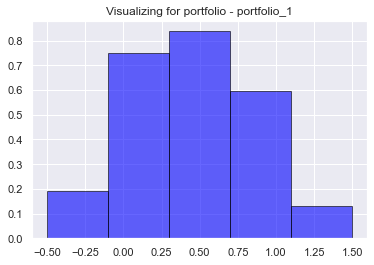

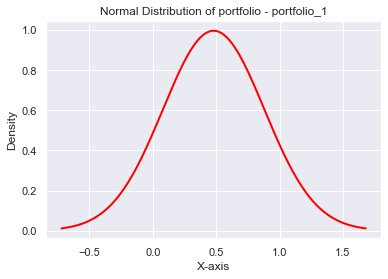

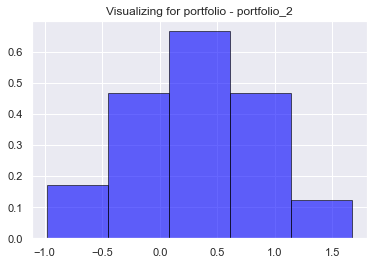

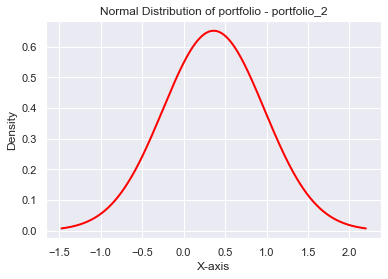

In [109]:
for k in pFolioLogReturn:
    plt.title(f"Visualizing for portfolio - {k}")
    xAxis = pFolioLogReturn[k].LogReturn
    meanRetrn = xAxis.mean()
    stdDiv = xAxis.std()
    samples = len(portfolios[k])
    data = np.random.normal(meanRetrn, stdDiv, samples)
    plt.hist(data, bins=5, density=True, alpha=0.6, color='blue', edgecolor='black')
    plt.show()

    x = np.linspace(meanRetrn - 3 * stdDiv, meanRetrn + 3 * stdDiv, 1000)
    y = 1 / (stdDiv * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - meanRetrn) / stdDiv) ** 2)
    plt.plot(x, y, color='red', linewidth=2)

    # Set labels and title
    plt.xlabel("X-axis")
    plt.ylabel("Density")
    plt.title(f"Normal Distribution of portfolio - {k}")

    plt.show()

<h4>Visualizing cumulative returns of entire portfolio

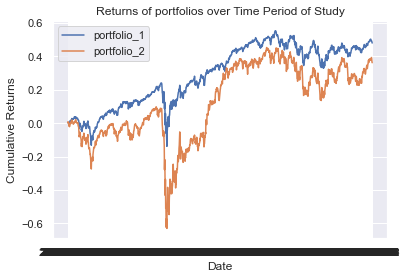

In [110]:
for k in pFolioLog:
    plt.plot(pFolioLog[k].diff().mean(axis=1).cumsum(), label=k)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.title(f'Returns of portfolios over Time Period of Study')
    plt.legend()

<h4>Visualizing log returns and percent changes in asset price

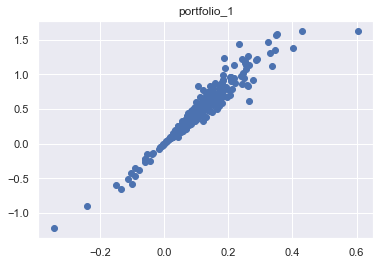

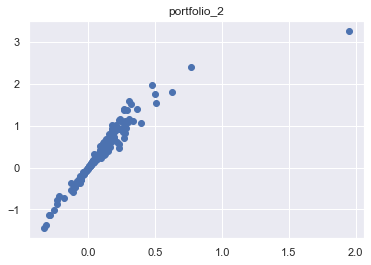

In [111]:
for k in pFolioLog:
    percent_returns = (pFolioLog[k].iloc[-1].T / pFolioLog[k].iloc[0].T) - 1
    percent_returns = percent_returns.loc[pFolioLogReturn[k].index]
    plt.scatter(percent_returns, pFolioLogReturn[k])
    plt.title(k)
    plt.show()

<h3>Build Fundamental Dataset for each portfolios

<h4>Merging Fundamental & Log return dataset for Portfolio 1

In [113]:
portfolio1 = pd.merge(fundatmentalData, pFolioLogReturn['portfolio_1'], left_index=True, right_index=True)
portfolio1.head()

Operating_Cash_Flow_(ttm) Gross_Profit_(ttm) Enterprise_Value  \
CTRA                      5.63               7.64            22.51   
EQT                       4.31               9.72            18.53   
AEE                        2.5               3.34            37.75   
AEP                       4.18               8.41            87.44   
ATO                       3.27               1.81            23.95   

     Revenue_(ttm) EBITDA Market_Cap_(intraday)  Float_8  \
CTRA          9.09   6.97                 20.91  0.70317   
EQT           8.85   6.62                 15.07  0.35897   
AEE           7.88   3.06                 22.23  0.26121   
AEP          19.47   6.81                 43.29  0.51452   
ATO           4.41   1.61                 17.49  0.13842   

     Operating_Margin_(ttm) Return_on_Assets_(ttm) Profit_Margin  ...  \
CTRA                 0.5866                 0.1646         0.455  ...   
EQT                  0.5655                 0.1425         0.401  ...   
AEE                  0.2207                 0.0286        0.1416  ...   
AEP                  0.1916                 0.0249         0.102  ...   
ATO                  0.2328                 0.0295        0.1902  ...   

     Diluted_EPS_(ttm) Enterprise_Value/EBITDA Total_Cash_Per_Share_(mrq)  \
CTRA              5.22                    3.21                       1.28   
EQT                9.0                    2.88                       3.36   
AEE               4.17                   11.65                       0.03   
AEP               3.85                   13.09                       0.99   
ATO               5.76                   14.68                       0.38   

     Beta_(5Y_Monthly) Forward_Annual_Dividend_Rate_4  \
CTRA              0.28                            2.1   
EQT               1.21                            0.6   
AEE                NaN                           2.52   
AEP               0.45                           3.32   
ATO                NaN                           2.96   

     Book_Value_Per_Share_(mrq) Price/Sales_(ttm) Forward_P/E  \
CTRA                       16.7              2.38       12.59   
EQT                        33.2              1.94       17.24   
AEE                       40.74              2.71       19.42   
AEP                        46.4              2.23       15.87   
ATO                       71.98              3.76       18.73   

     200-Day_Moving_Average_3 LogReturn  
CTRA                    25.62  0.383047  
EQT                     36.01  0.466028  
AEE                     85.37  0.414683  
AEP                     90.01  0.317468  
ATO                    114.45  0.378654  

[5 rows x 27 columns]

<h4>Merging Fundamental & Log return dataset for Portfolio 2

In [114]:
portfolio2 = pd.merge(fundatmentalData, pFolioLogReturn['portfolio_2'], left_index=True, right_index=True)
portfolio2.head()

Operating_Cash_Flow_(ttm) Gross_Profit_(ttm) Enterprise_Value  \
APA                      4.39               7.64            18.21   
BKR                      2.82               4.43            39.95   
COP                     28.65               39.6           150.01   
CVX                      41.3              98.89           310.82   
DVN                       7.1              11.33            40.24   

    Revenue_(ttm) EBITDA Market_Cap_(intraday)  Float_8  \
APA         10.22   6.14                 12.42  0.28989   
BKR          23.3   3.34                 36.12  0.96303   
COP          77.7  32.63                142.04     1.21   
CVX        214.19  51.04                303.41     1.76   
DVN         15.96   8.85                 34.45  0.63671   

    Operating_Margin_(ttm) Return_on_Assets_(ttm) Profit_Margin  ...  \
APA                 0.4621                 0.2299        0.1989  ...   
BKR                 0.0982                 0.0409        0.0494  ...   
COP                 0.3207                 0.1686        0.2039  ...   
CVX                 0.1681                    NaN        0.1408  ...   
DVN                 0.3985                 0.1708        0.2995  ...   

    Diluted_EPS_(ttm) Enterprise_Value/EBITDA Total_Cash_Per_Share_(mrq)  \
APA              6.37                    3.12                        0.5   
BKR              1.15                   12.61                       3.81   
COP             12.56                    4.47                       7.11   
CVX             18.52                    6.01                       8.34   
DVN              9.17                    3.85                       0.58   

    Beta_(5Y_Monthly) Forward_Annual_Dividend_Rate_4  \
APA              3.52                            1.0   
BKR              1.51                            0.8   
COP              1.32                            2.4   
CVX              1.16                           6.04   
DVN              2.34                           4.51   

    Book_Value_Per_Share_(mrq) Price/Sales_(ttm) Forward_P/E  \
APA                       1.44              1.25        7.36   
BKR                      14.99              1.55       22.37   
COP                      39.49              1.95       12.64   
CVX                      84.18              1.45       12.18   
DVN                      17.19              1.82        8.84   

    200-Day_Moving_Average_3 LogReturn  
APA                    39.67  0.023198  
BKR                    29.86  0.215687  
COP                   110.97  0.655634  
CVX                   166.87  0.480712  
DVN                    57.16  0.418983  

[5 rows x 27 columns]

<h3>Portfolio 1 Exploration and Wrangling

<h4>Size of the dataset

In [115]:
portfolio1.shape

(290, 27)

<h4>Information on Dataset

In [116]:
portfolio1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290 entries, CTRA to VRSN
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Operating_Cash_Flow_(ttm)       228 non-null    object
 1   Gross_Profit_(ttm)              277 non-null    object
 2   Enterprise_Value                290 non-null    object
 3   Revenue_(ttm)                   244 non-null    object
 4   EBITDA                          244 non-null    object
 5   Market_Cap_(intraday)           290 non-null    object
 6   Float_8                         244 non-null    object
 7   Operating_Margin_(ttm)          244 non-null    object
 8   Return_on_Assets_(ttm)          236 non-null    object
 9   Profit_Margin                   244 non-null    object
 10  Quarterly_Revenue_Growth_(yoy)  244 non-null    object
 11  Price/Book_(mrq)                274 non-null    object
 12  Revenue_Per_Share_(ttm)         244 non-null    obj

In [242]:
portfolio1.to_csv('test.csv')

<h4>Convert each object to float

In [130]:
portfolio1=portfolio1.apply(pd.to_numeric)
portfolio1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290 entries, CTRA to VRSN
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Operating_Cash_Flow_(ttm)       290 non-null    float64
 1   Gross_Profit_(ttm)              290 non-null    float64
 2   Enterprise_Value                290 non-null    float64
 3   Revenue_(ttm)                   290 non-null    float64
 4   EBITDA                          290 non-null    float64
 5   Market_Cap_(intraday)           290 non-null    float64
 6   Float_8                         290 non-null    float64
 7   Operating_Margin_(ttm)          290 non-null    float64
 8   Return_on_Assets_(ttm)          290 non-null    float64
 9   Profit_Margin                   290 non-null    float64
 10  Quarterly_Revenue_Growth_(yoy)  290 non-null    float64
 11  Price/Book_(mrq)                290 non-null    float64
 12  Revenue_Per_Share_(ttm)         290 n

<h4>Describing the Data

In [131]:
portfolio1.describe()

Operating_Cash_Flow_(ttm)  Gross_Profit_(ttm)  Enterprise_Value  \
count                 290.000000          290.000000        290.000000   
mean                    0.071824            0.161360          0.034662   
std                     0.095302            0.106641          0.092815   
min                     0.000000            0.000000          0.000000   
25%                     0.035142            0.119817          0.004730   
50%                     0.043740            0.128909          0.012027   
75%                     0.070020            0.147380          0.026394   
max                     1.000000            1.000000          1.000000   

       Revenue_(ttm)      EBITDA  Market_Cap_(intraday)     Float_8  \
count     290.000000  290.000000             290.000000  290.000000   
mean        0.057918    0.071284               0.032394    0.040948   
std         0.120460    0.094036               0.094215    0.085601   
min         0.000000    0.000000               0.000000    0.000000   
25%         0.008260    0.033407               0.004710    0.008754   
50%         0.019125    0.043721               0.010354    0.017054   
75%         0.049867    0.071632               0.023361    0.037391   
max         1.000000    1.000000               1.000000    1.000000   

       Operating_Margin_(ttm)  Return_on_Assets_(ttm)  Profit_Margin  ...  \
count              290.000000              290.000000     290.000000  ...   
mean                 0.422571                0.324470       0.678435  ...   
std                  0.153505                0.129319       0.065229  ...   
min                  0.000000                0.000000       0.000000  ...   
25%                  0.333395                0.232887       0.655419  ...   
50%                  0.407600                0.298626       0.675995  ...   
75%                  0.496107                0.392805       0.701910  ...   
max                  1.000000                1.000000       1.000000  ...   

       Diluted_EPS_(ttm)  Enterprise_Value/EBITDA  Total_Cash_Per_Share_(mrq)  \
count         290.000000               290.000000                  290.000000   
mean            0.071664                 0.523396                    0.005639   
std             0.058132                 0.062826                    0.062002   
min             0.000000                 0.000000                    0.000000   
25%             0.060579                 0.507000                    0.000017   
50%             0.064970                 0.519328                    0.000042   
75%             0.071720                 0.535420                    0.000098   
max             1.000000                 1.000000                    1.000000   

       Beta_(5Y_Monthly)  Forward_Annual_Dividend_Rate_4  \
count         290.000000                      290.000000   
mean            0.521716                        0.209143   
std             0.199657                        0.153085   
min             0.000000                        0.000000   
25%             0.389313                        0.098802   
50%             0.526718                        0.185105   
75%             0.664122                        0.280689   
max             1.000000                        1.000000   

       Book_Value_Per_Share_(mrq)  Price/Sales_(ttm)  Forward_P/E  \
count                  290.000000         290.000000   290.000000   
mean                     0.006294           0.240172     0.112307   
std                      0.061959           0.205196     0.100892   
min                      0.000000           0.000000     0.000000   
25%                      0.000715           0.089978     0.061911   
50%                      0.000750           0.178610     0.088416   
75%                      0.000813           0.310075     0.125849   
max                      1.000000           1.000000     1.000000   

       200-Day_Moving_Average_3   LogReturn  
count                290.000000  290.000000  
mean                 

<h4>Fill Missing Data

In [132]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [133]:
#Define a subset of the dataset
portfolio1 = portfolio1.copy()

# Define scaler to set values between 0 and 1

scaler = MinMaxScaler(feature_range=(0, 1))
portfolio1 = pd.DataFrame(scaler.fit_transform(portfolio1), index=portfolio1.index, columns = portfolio1.columns)
# portfolio1 = pd.DataFrame(portfolio1, index=portfolio1.index, columns = portfolio1.columns)

# Define KNN imputer and fill missing values
knnImputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
portfolio1 = pd.DataFrame(knnImputer.fit_transform(portfolio1), index=portfolio1.index, columns=portfolio1.columns)

In [134]:
portfolio1.describe()

Operating_Cash_Flow_(ttm)  Gross_Profit_(ttm)  Enterprise_Value  \
count                 290.000000          290.000000        290.000000   
mean                    0.071824            0.161360          0.034662   
std                     0.095302            0.106641          0.092815   
min                     0.000000            0.000000          0.000000   
25%                     0.035142            0.119817          0.004730   
50%                     0.043740            0.128909          0.012027   
75%                     0.070020            0.147380          0.026394   
max                     1.000000            1.000000          1.000000   

       Revenue_(ttm)      EBITDA  Market_Cap_(intraday)     Float_8  \
count     290.000000  290.000000             290.000000  290.000000   
mean        0.057918    0.071284               0.032394    0.040948   
std         0.120460    0.094036               0.094215    0.085601   
min         0.000000    0.000000               0.000000    0.000000   
25%         0.008260    0.033407               0.004710    0.008754   
50%         0.019125    0.043721               0.010354    0.017054   
75%         0.049867    0.071632               0.023361    0.037391   
max         1.000000    1.000000               1.000000    1.000000   

       Operating_Margin_(ttm)  Return_on_Assets_(ttm)  Profit_Margin  ...  \
count              290.000000              290.000000     290.000000  ...   
mean                 0.422571                0.324470       0.678435  ...   
std                  0.153505                0.129319       0.065229  ...   
min                  0.000000                0.000000       0.000000  ...   
25%                  0.333395                0.232887       0.655419  ...   
50%                  0.407600                0.298626       0.675995  ...   
75%                  0.496107                0.392805       0.701910  ...   
max                  1.000000                1.000000       1.000000  ...   

       Diluted_EPS_(ttm)  Enterprise_Value/EBITDA  Total_Cash_Per_Share_(mrq)  \
count         290.000000               290.000000                  290.000000   
mean            0.071664                 0.523396                    0.005639   
std             0.058132                 0.062826                    0.062002   
min             0.000000                 0.000000                    0.000000   
25%             0.060579                 0.507000                    0.000017   
50%             0.064970                 0.519328                    0.000042   
75%             0.071720                 0.535420                    0.000098   
max             1.000000                 1.000000                    1.000000   

       Beta_(5Y_Monthly)  Forward_Annual_Dividend_Rate_4  \
count         290.000000                      290.000000   
mean            0.521716                        0.209143   
std             0.199657                        0.153085   
min             0.000000                        0.000000   
25%             0.389313                        0.098802   
50%             0.526718                        0.185105   
75%             0.664122                        0.280689   
max             1.000000                        1.000000   

       Book_Value_Per_Share_(mrq)  Price/Sales_(ttm)  Forward_P/E  \
count                  290.000000         290.000000   290.000000   
mean                     0.006294           0.240172     0.112307   
std                      0.061959           0.205196     0.100892   
min                      0.000000           0.000000     0.000000   
25%                      0.000715           0.089978     0.061911   
50%                      0.000750           0.178610     0.088416   
75%                      0.000813           0.310075     0.125849   
max                      1.000000           1.000000     1.000000   

       200-Day_Moving_Average_3   LogReturn  
count                290.000000  290.000000  
mean                 

<AxesSubplot:>

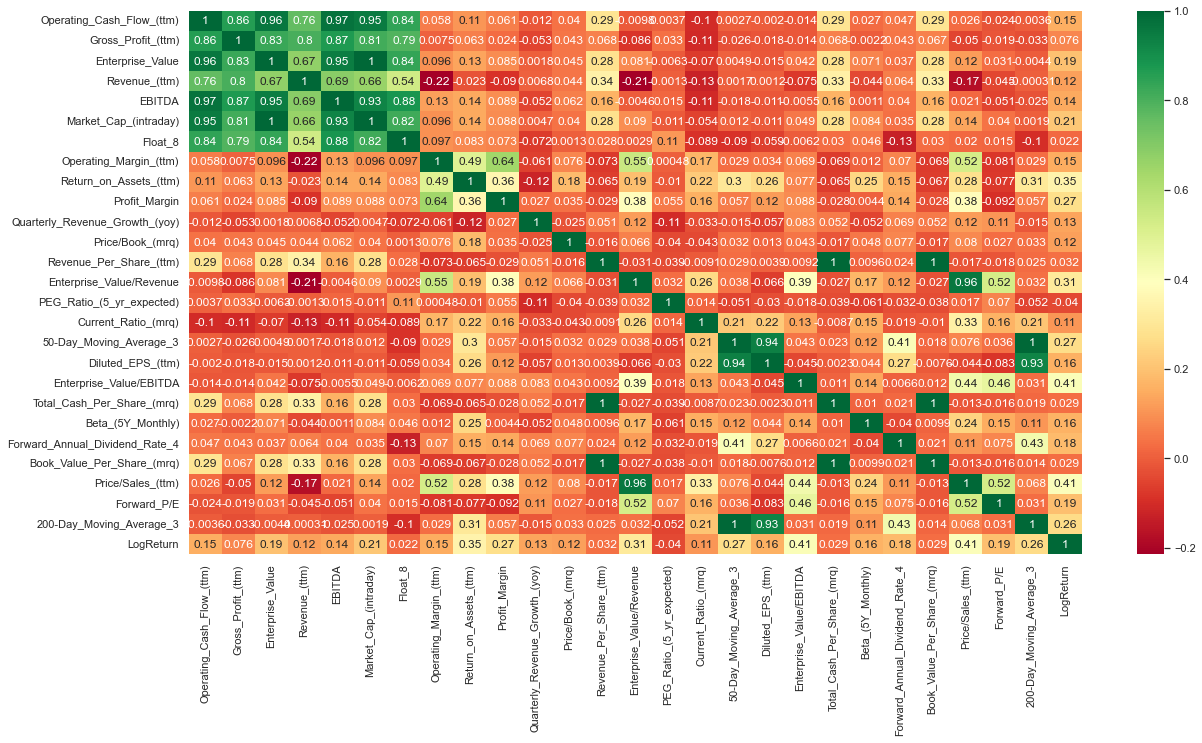

In [135]:
plt.figure(figsize=(20,10))
sns.heatmap(portfolio1.corr(), annot=True,cmap ='RdYlGn')

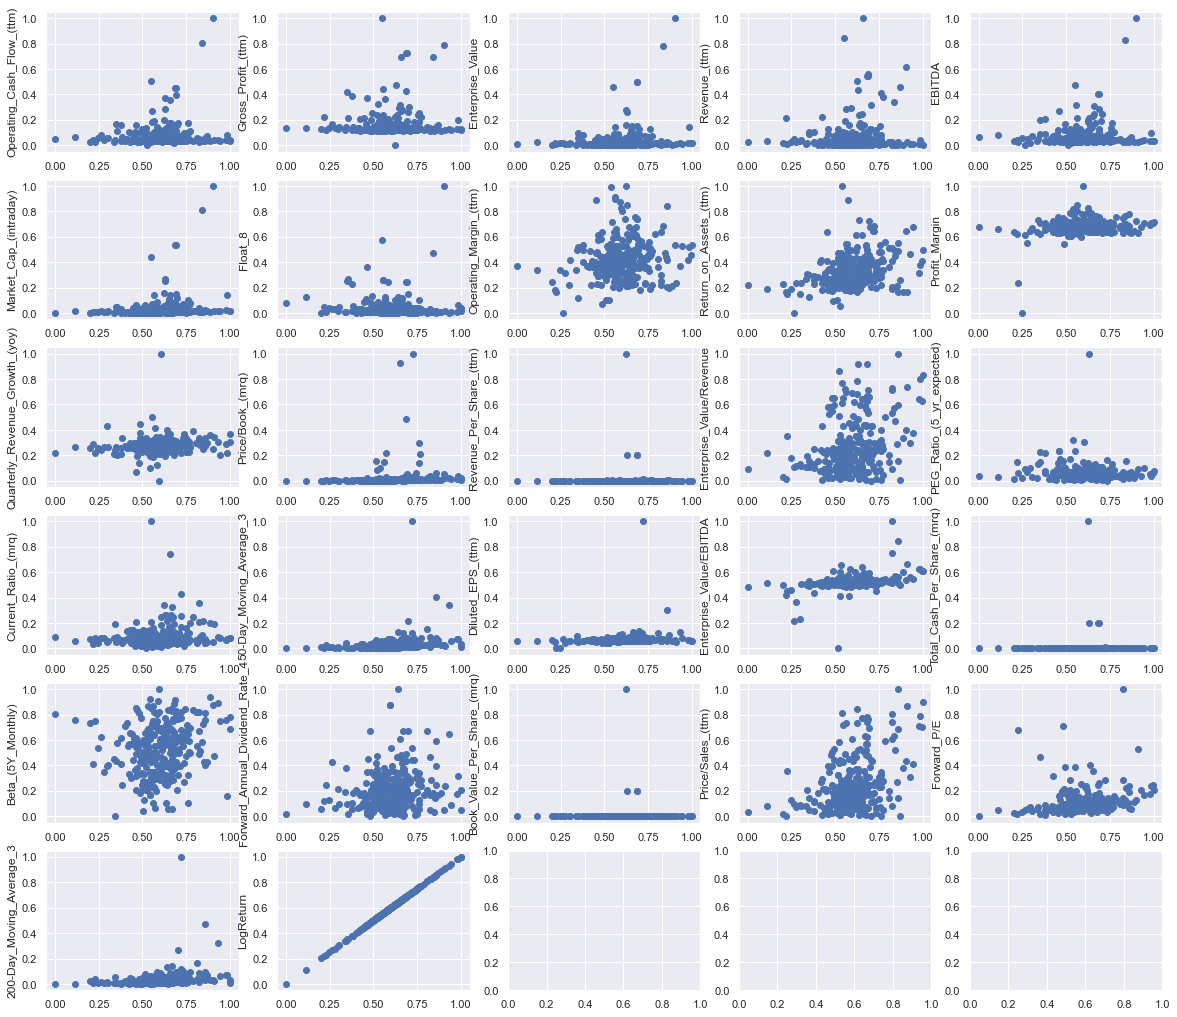

In [137]:
import math
i,j=0,0
PLOTS_PER_ROW = 5
fig, axs = plt.subplots(math.ceil(len(portfolio1.columns)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 18))
for col in portfolio1.columns:
    axs[i][j].scatter(np.array(portfolio1['LogReturn']), np.array(portfolio1[col]))
    # axs[i][j].scatter(portfolio1['LogReturn'], portfolio1[col])
    axs[i][j].set_ylabel(col)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.show()

<h3>Portfolio 2 Exploration and Wrangling

<h4>Size of the dataset

In [138]:
portfolio2.shape

(199, 27)

<h4>Information on Dataset

In [128]:
portfolio2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199 entries, APA to ZBRA
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Operating_Cash_Flow_(ttm)       146 non-null    object
 1   Gross_Profit_(ttm)              189 non-null    object
 2   Enterprise_Value                173 non-null    object
 3   Revenue_(ttm)                   171 non-null    object
 4   EBITDA                          144 non-null    object
 5   Market_Cap_(intraday)           199 non-null    object
 6   Float_8                         171 non-null    object
 7   Operating_Margin_(ttm)          171 non-null    object
 8   Return_on_Assets_(ttm)          162 non-null    object
 9   Profit_Margin                   171 non-null    object
 10  Quarterly_Revenue_Growth_(yoy)  171 non-null    object
 11  Price/Book_(mrq)                188 non-null    object
 12  Revenue_Per_Share_(ttm)         171 non-null    obje

<h4>Convert each object to float

In [139]:
portfolio2=portfolio2.apply(pd.to_numeric)
portfolio2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199 entries, APA to ZBRA
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Operating_Cash_Flow_(ttm)       146 non-null    float64
 1   Gross_Profit_(ttm)              189 non-null    float64
 2   Enterprise_Value                173 non-null    float64
 3   Revenue_(ttm)                   171 non-null    float64
 4   EBITDA                          144 non-null    float64
 5   Market_Cap_(intraday)           199 non-null    float64
 6   Float_8                         171 non-null    float64
 7   Operating_Margin_(ttm)          171 non-null    float64
 8   Return_on_Assets_(ttm)          162 non-null    float64
 9   Profit_Margin                   171 non-null    float64
 10  Quarterly_Revenue_Growth_(yoy)  171 non-null    float64
 11  Price/Book_(mrq)                188 non-null    float64
 12  Revenue_Per_Share_(ttm)         171 no

<h4>Describing the Data

In [140]:
portfolio2.describe()

Operating_Cash_Flow_(ttm)  Gross_Profit_(ttm)  Enterprise_Value  \
count                 146.000000          189.000000        173.000000   
mean                    5.268202           11.041724         64.808902   
std                     8.463799           18.207476        120.099954   
min                    -0.408000           -1.730000          4.830000   
25%                     1.140000            2.800000         18.480000   
50%                     2.835000            5.420000         33.470000   
75%                     5.727500           11.440000         64.920000   
max                    67.770000          133.720000       1150.000000   

       Revenue_(ttm)      EBITDA  Market_Cap_(intraday)     Float_8  \
count     171.000000  144.000000             199.000000  171.000000   
mean       28.299006    5.315411              58.401608    0.581386   
std        44.057330    9.143408             117.130938    0.849373   
min         1.110000   -5.150000               4.470000    0.024220   
25%         6.775000    1.375000              14.175000    0.166430   
50%        14.070000    2.745000              26.700000    0.304360   
75%        26.135000    5.610000              51.345000    0.641465   
max       367.980000   83.740000            1150.000000    7.920000   

       Operating_Margin_(ttm)  Return_on_Assets_(ttm)  Profit_Margin  ...  \
count              171.000000              162.000000     171.000000  ...   
mean                 0.207284                0.061177       0.143696  ...   
std                  0.160118                0.055859       0.142143  ...   
min                 -0.339100               -0.028500      -0.324200  ...   
25%                  0.098650                0.016750       0.050750  ...   
50%                  0.179500                0.045700       0.130100  ...   
75%                  0.299050                0.091300       0.228700  ...   
max                  0.870200                0.250400       0.641400  ...   

       Diluted_EPS_(ttm)  Enterprise_Value/EBITDA  Total_Cash_Per_Share_(mrq)  \
count         171.000000               163.000000                  169.000000   
mean            7.146140                12.821104                   40.457574   
std            11.465068                60.269694                  167.254542   
min           -27.070000              -702.990000                    0.100000   
25%             1.910000                 8.240000                    2.910000   
50%             4.660000                13.160000                    7.500000   
75%             8.960000                19.565000                   19.330000   
max           100.070000               177.900000                 1960.270000   

       Beta_(5Y_Monthly)  Forward_Annual_Dividend_Rate_4  \
count         156.000000                      135.000000   
mean            1.401538                        2.714296   
std             0.385745                        3.280909   
min             0.710000                        0.010000   
25%             1.167500                        0.980000   
50%             1.350000                        1.800000   
75%             1.542500                        3.350000   
max             3.520000                       23.200000   

       Book_Value_Per_Share_(mrq)  Price/Sales_(ttm)  Forward_P/E  \
count                  171.000000         199.000000   196.000000   
mean                    37.192105           3.306633    21.259133   
std                     39.234462           4.266626    21.372826   
min                    -28.280000           0.210000     3.910000   
25%                     14.240000           1.160000    10.375000   
50%                     31.660000           2.180000    14.915000   
75%                     45.220000           3.625000    24.480000   
max                    307.620000          44.840000   208.330000   

       200-Day_Moving_Average_3   LogReturn  
count                199.000000  199.000000  
mean                 

<h4>Fill Missing Data

In [143]:
#Define a subset of the dataset
portfolio2 = portfolio2.copy()

# Define scaler to set values between 0 and 1

scaler2 = MinMaxScaler(feature_range=(0, 1))
portfolio2 = pd.DataFrame(scaler2.fit_transform(portfolio2), index=portfolio2.index, columns = portfolio2.columns)

# portfolio2 = pd.DataFrame(portfolio2, index=portfolio2.index, columns = portfolio2.columns)

# Define KNN imputer and fill missing values
knnImputer2 = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
portfolio2 = pd.DataFrame(knnImputer2.fit_transform(portfolio2), index=portfolio2.index, columns=portfolio2.columns)

In [144]:
portfolio2.describe()

Operating_Cash_Flow_(ttm)  Gross_Profit_(ttm)  Enterprise_Value  \
count                 199.000000          199.000000        199.000000   
mean                    0.079441            0.091971          0.051429   
std                     0.111030            0.131434          0.098680   
min                     0.000000            0.000000          0.000000   
25%                     0.025849            0.033223          0.013090   
50%                     0.047053            0.051458          0.024669   
75%                     0.088812            0.092100          0.053394   
max                     1.000000            1.000000          1.000000   

       Revenue_(ttm)      EBITDA  Market_Cap_(intraday)     Float_8  \
count     199.000000  199.000000             199.000000  199.000000   
mean        0.069005    0.116200               0.047080    0.065503   
std         0.112425    0.095406               0.102250    0.100899   
min         0.000000    0.000000               0.000000    0.000000   
25%         0.017704    0.076539               0.008472    0.018273   
50%         0.033047    0.090899               0.019406    0.034944   
75%         0.061261    0.115424               0.040920    0.070778   
max         1.000000    1.000000               1.000000    1.000000   

       Operating_Margin_(ttm)  Return_on_Assets_(ttm)  Profit_Margin  ...  \
count              199.000000              199.000000     199.000000  ...   
mean                 0.446653                0.324578       0.478569  ...   
std                  0.125609                0.190505       0.139954  ...   
min                  0.000000                0.000000       0.000000  ...   
25%                  0.364674                0.182503       0.389499  ...   
50%                  0.428182                0.273933       0.466176  ...   
75%                  0.523286                0.428828       0.557943  ...   
max                  1.000000                1.000000       1.000000  ...   

       Diluted_EPS_(ttm)  Enterprise_Value/EBITDA  Total_Cash_Per_Share_(mrq)  \
count         199.000000               199.000000                  199.000000   
mean            0.268426                 0.811988                    0.018306   
std             0.085734                 0.061911                    0.078797   
min             0.000000                 0.000000                    0.000000   
25%             0.227938                 0.807399                    0.001594   
50%             0.250354                 0.811248                    0.003885   
75%             0.280832                 0.817906                    0.009724   
max             1.000000                 1.000000                    1.000000   

       Beta_(5Y_Monthly)  Forward_Annual_Dividend_Rate_4  \
count         199.000000                      199.000000   
mean            0.245798                        0.108434   
std             0.125375                        0.122784   
min             0.000000                        0.000000   
25%             0.176157                        0.042691   
50%             0.231317                        0.076757   
75%             0.295374                        0.128935   
max             1.000000                        1.000000   

       Book_Value_Per_Share_(mrq)  Price/Sales_(ttm)  Forward_P/E  \
count                  199.000000         199.000000   199.000000   
mean                     0.195040           0.069385     0.085078   
std                      0.109415           0.095600     0.104131   
min                      0.000000           0.000000     0.000000   
25%                      0.131661           0.021286     0.031675   
50%                      0.181512           0.044141     0.053762   
75%                      0.219074           0.076518     0.100773   
max                      1.000000           1.000000     1.000000   

       200-Day_Moving_Average_3   LogReturn  
count                199.000000  199.000000  
mean                 

In [145]:
plt.figure(figsize=(20,10))
sns.heatmap(portfolio2.corr(), annot=True,cmap ='RdYlGn')

<AxesSubplot:>

In [146]:
import math
i,j=0,0
PLOTS_PER_ROW = 5
fig, axs = plt.subplots(math.ceil(len(portfolio2.columns)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 18))
for col in portfolio2.columns:
    axs[i][j].scatter(np.array(portfolio2['LogReturn']), np.array(portfolio2[col]))
    # axs[i][j].scatter(portfolio1['LogReturn'], portfolio1[col])
    axs[i][j].set_ylabel(col)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.show()

<h3>Feature Engineering

<h4>Capital Asset Pricing Model (CAPM)</h4>
<p>The Capital Asset Pricing Model, or CAPM, calculates the value of a security based on the expected return relative to the risk investors incur by investing in that security.

To calculate the value of a stock using CAPM, multiply the volatility, known as "beta," by the additional compensation for incurring risk, known as the "Market Risk Premium," then add the risk-free rate to that value.

<b>Formula is-</b>
            <br><center>Cost of Equity = Risk-Free Rate of Return + Beta * (Market Rate of Return - Risk-Free Rate of Return)

<h4>Risk Free Return</h4>
<p>The risk-free rate of return is the theoretical rate of return of an investment with zero risk. The risk-free rate represents the interest an investor would expect from an absolutely risk-free investment over a specified period of time.

The so-called "real" risk-free rate can be calculated by subtracting the current inflation rate from the yield of the Treasury bond matching your investment duration.</p>

<b>Formula is-</b>
<p><center> Risk Free Rate of Return = [1+Govt Bond Rate/1+Inflation Rate]-1</center>

As per recent data Govt bond rate in USA is 3.962% and Inflation rate is 2.97%.
<br>Source:
<p>https://ycharts.com/indicators/us_inflation_rate#:~:text=US%20Inflation%20Rate%20(I%3AUSIR)&text=US%20Inflation%20Rate%20is%20at,in%20price%20over%20a%20year

<p>http://www.worldgovernmentbonds.com/country/united-states/

Reference: 
https://www.investopedia.com/terms/r/risk-freerate.asp#:~:text=The%20risk%2Dfree%20rate%20represents,bond%20matching%20your%20investment%20duration.

https://www.investopedia.com/ask/answers/022515/how-do-i-use-capm-capital-asset-pricing-model-determine-cost-equity.asp

In [147]:
#Risk Free Return
numrtr = 1+3.962
dnmrtr = 1+2.97
div = numrtr/dnmrtr
rf = div-1
print(f"Risk Free Rate for Return = {rf}")

Risk Free Rate for Return = 0.2498740554156169


Let's consider price data return to be market return here; so to calculate CAPM we need market return, in our scenario, we are going to take initial return calculated on pricing data as market return.

In [148]:
weight = np.random.random(len(fDframe))
weight /= weight.sum()
weight=np.array(weight)
print(f"Asset weight is\n {weight}")

Asset weight is
 [0.00138 0.00225 0.00027 0.0024  0.0009  0.00076 0.00385 0.00403 0.00373
 0.00122 0.0016  0.00403 0.00335 0.00327 0.00276 0.00355 0.00164 0.0011
 0.00335 0.00051 0.00309 0.00228 0.0017  0.00118 0.00393 0.00413 0.00269
 0.00109 0.00132 0.0029  0.0009  0.00226 0.004   0.00097 0.00361 0.00152
 0.00018 0.00407 0.00205 0.00383 0.00422 0.00044 0.00083 0.0004  0.001
 0.00194 0.00415 0.00094 0.00081 0.0016  0.002   0.00334 0.0031  0.0001
 0.00193 0.00231 0.00305 0.00252 0.00017 0.00352 0.00252 0.00052 0.00325
 0.00106 0.00136 0.00104 0.00072 0.00275 0.00068 0.00287 0.00238 0.00404
 0.00336 0.00127 0.00229 0.00067 0.00154 0.00356 0.00288 0.00165 0.00222
 0.00252 0.00008 0.00311 0.00188 0.00141 0.      0.00206 0.00142 0.0022
 0.00177 0.00016 0.00234 0.00105 0.00101 0.00056 0.00125 0.00193 0.00226
 0.00205 0.00059 0.003   0.00221 0.00406 0.00132 0.00335 0.00053 0.00395
 0.0018  0.00055 0.001   0.00241 0.00038 0.00064 0.00163 0.0009  0.0034
 0.00278 0.00251 0.00285 0.00335 0.00234

In [149]:
expectedPortfolioReturn = meanReturns.T@weight
marketReturn = 251*np.array(expectedPortfolioReturn) 

Let's calculate (Market Rate of Return - Risk-Free Rate of Return)-

In [150]:
mrSubrf = marketReturn-rf
mrSubrf[0]

16.021928213050955

We already have Beta in portfolio1 and portfolio2 datasets. let's multiply above result with Beta.

In [151]:
#Temporary dataframe to calculate CAPM for portfoliio1
tempPortfolio1 = pd.DataFrame(index=portfolio1.index, columns=['Beta_(5Y_Monthly)', 'mrSubrf', 'Cost_of_Equity'])
tempPortfolio1['Beta_(5Y_Monthly)']=portfolio1['Beta_(5Y_Monthly)']
tempPortfolio1['mrSubrf']=tempPortfolio1['Beta_(5Y_Monthly)']*mrSubrf[0]
tempPortfolio1['Cost_of_Equity']=tempPortfolio1['mrSubrf']+rf
portfolio1['Cost_of_Equity']=tempPortfolio1['Cost_of_Equity']

#Temporary dataframe to calculate CAPM for portfoliio2
tempPortfolio2 = pd.DataFrame(index=portfolio2.index, columns=['Beta_(5Y_Monthly)', 'mrSubrf', 'Cost_of_Equity'])
tempPortfolio2['Beta_(5Y_Monthly)']=portfolio2['Beta_(5Y_Monthly)']
tempPortfolio2['mrSubrf']=tempPortfolio2['Beta_(5Y_Monthly)']*mrSubrf[0]
tempPortfolio2['Cost_of_Equity']=tempPortfolio2['mrSubrf']+rf
portfolio2['Cost_of_Equity']=tempPortfolio2['Cost_of_Equity']

In [152]:
portfolio1.head()

Operating_Cash_Flow_(ttm)  Gross_Profit_(ttm)  Enterprise_Value  \
CTRA                   0.075918            0.141091          0.004718   
EQT                    0.064183            0.149305          0.003443   
AEE                    0.048093            0.124112          0.009599   
AEP                    0.063028            0.144132          0.025514   
ATO                    0.054938            0.118070          0.005179   

      Revenue_(ttm)    EBITDA  Market_Cap_(intraday)   Float_8  \
CTRA       0.013451  0.077397               0.005375  0.044685   
EQT        0.013065  0.074633               0.003476  0.022774   
AEE        0.011503  0.046517               0.005804  0.016551   
AEP        0.030158  0.076133               0.012651  0.032676   
ATO        0.005918  0.035066               0.004263  0.008734   

      Operating_Margin_(ttm)  Return_on_Assets_(ttm)  Profit_Margin  ...  \
CTRA                0.896157                0.545192       0.803606  ...   
EQT                 0.870165                0.491926       0.782668  ...   
AEE                 0.445430                0.217402       0.682086  ...   
AEP                 0.409584                0.208484       0.666731  ...   
ATO                 0.460335                0.219571       0.700931  ...   

      Enterprise_Value/EBITDA  Total_Cash_Per_Share_(mrq)  Beta_(5Y_Monthly)  \
CTRA                 0.482311                    0.000014           0.106870   
EQT                  0.481402                    0.000037           0.816794   
AEE                  0.505548                    0.000000           0.305344   
AEP                  0.509512                    0.000011           0.236641   
ATO                  0.513890                    0.000004           0.430534   

      Forward_Annual_Dividend_Rate_4  Book_Value_Per_Share_(mrq)  \
CTRA                        0.136228                    0.000726   
EQT                         0.023952                    0.000774   
AEE                         0.167665                    0.000795   
AEP                         0.227545                    0.000811   
ATO                         0.200599                    0.000885   

      Price/Sales_(ttm)  Forward_P/E  200-Day_Moving_Average_3  LogReturn  \
CTRA           0.121767     0.044098                  0.002879   0.563039   
EQT            0.098060     0.066807                  0.004846   0.592115   
AEE            0.139547     0.077453                  0.014191   0.574124   
AEP            0.113685     0.060116                  0.015069   0.540060   
ATO            0.196121     0.074083                  0.019696   0.561499   

      Cost_of_Equity  
CTRA        1.962141  
EQT        13.336487  
AEE         5.142066  
AEP         4.041323  
ATO         7.147865  

[5 rows x 28 columns]

In [153]:
portfolio1['Cost_of_Equity'].plot()
portfolio1['LogReturn'].plot()

<AxesSubplot:>

In [154]:
plt.figure(figsize = (30,15))
#corr = df3.corr()
sns.heatmap(portfolio1.corr(), annot = True, cmap = plt.cm.Accent)

sns.barplot

<function seaborn.categorical.barplot(*, x=None, y=None, hue=None, data=None, order=None, hue_order=None, estimator=<function mean at 0x000001ED335B9EA0>, ci=95, n_boot=1000, units=None, seed=None, orient=None, color=None, palette=None, saturation=0.75, errcolor='.26', errwidth=None, capsize=None, dodge=True, ax=None, **kwargs)>

In [158]:
portfolio2.head()

Operating_Cash_Flow_(ttm)  Gross_Profit_(ttm)  Enterprise_Value  \
APA                   0.070375            0.069177          0.011684   
BKR                   0.047347            0.045478          0.030668   
COP                   0.426208            0.305131          0.126776   
CVX                   0.611752            0.742857          0.267201   
DVN                   0.110124            0.096419          0.030921   

     Revenue_(ttm)    EBITDA  Market_Cap_(intraday)   Float_8  \
APA       0.024832  0.127011               0.006940  0.033647   
BKR       0.060485  0.095511               0.027629  0.118900   
COP       0.208766  0.425020               0.120093  0.150179   
CVX       0.580805  0.632130               0.260962  0.219836   
DVN       0.040478  0.157498               0.026171  0.077572   

     Operating_Margin_(ttm)  Return_on_Assets_(ttm)  Profit_Margin  ...  \
APA                0.662532                0.926497       0.541736  ...   
BKR                0.361614                0.248835       0.386910  ...   
COP                0.545605                0.706705       0.546914  ...   
CVX                0.419416                0.323127       0.481566  ...   
DVN                0.609940                0.714593       0.645920  ...   

     Enterprise_Value/EBITDA  Total_Cash_Per_Share_(mrq)  Beta_(5Y_Monthly)  \
APA                 0.801587                    0.000204           1.000000   
BKR                 0.812360                    0.001893           0.284698   
COP                 0.803120                    0.003576           0.217082   
CVX                 0.804868                    0.004204           0.160142   
DVN                 0.802416                    0.000245           0.580071   

     Forward_Annual_Dividend_Rate_4  Book_Value_Per_Share_(mrq)  \
APA                        0.042691                    0.088479   
BKR                        0.034066                    0.128818   
COP                        0.103062                    0.201756   
CVX                        0.260026                    0.334802   
DVN                        0.194049                    0.135368   

     Price/Sales_(ttm)  Forward_P/E  200-Day_Moving_Average_3  LogReturn  \
APA           0.023303     0.016877                  0.011855   0.312621   
BKR           0.030025     0.090304                  0.007764   0.353362   
COP           0.038987     0.042706                  0.041585   0.446478   
CVX           0.027784     0.040456                  0.064893   0.409456   
DVN           0.036074     0.024117                  0.019147   0.396390   

     Cost_of_Equity  
APA       16.271802  
BKR        4.811277  
COP        3.727944  
CVX        2.815663  
DVN        9.543733  

[5 rows x 28 columns]

<AxesSubplot:>

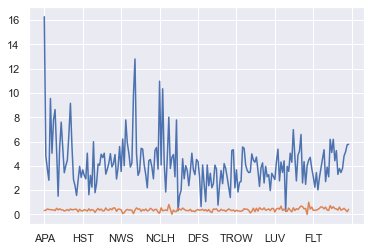

In [159]:
portfolio2['Cost_of_Equity'].plot()
portfolio2['LogReturn'].plot()

<function seaborn.categorical.barplot(*, x=None, y=None, hue=None, data=None, order=None, hue_order=None, estimator=<function mean at 0x000001ED335B9EA0>, ci=95, n_boot=1000, units=None, seed=None, orient=None, color=None, palette=None, saturation=0.75, errcolor='.26', errwidth=None, capsize=None, dodge=True, ax=None, **kwargs)>

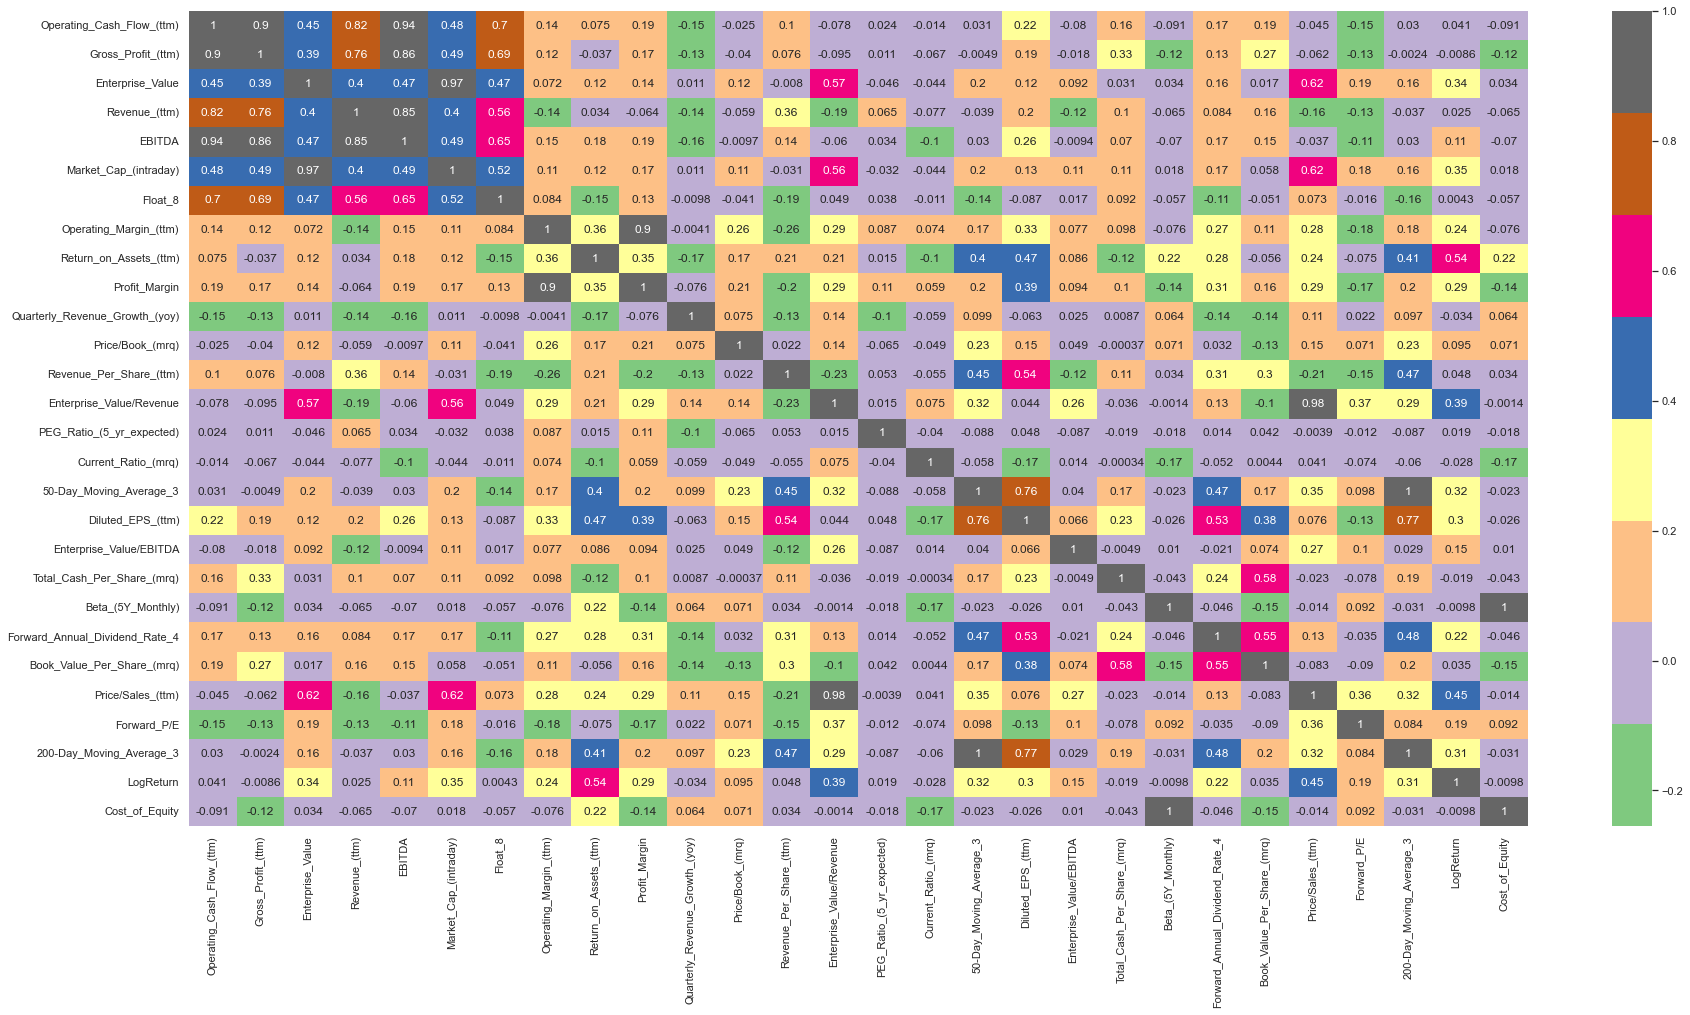

In [160]:
plt.figure(figsize = (30,15))
#corr = df3.corr()
sns.heatmap(portfolio2.corr(), annot = True, cmap = plt.cm.Accent)

sns.barplot

<h3>Train Test Split & Feature Ranking

In [161]:
#Splitting Dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
#To Determine mutual information

<h4>Train Test Split for Portfolio 1

In [162]:
X=portfolio1.drop(labels = ['LogReturn'], axis = 1)
Y=portfolio1['LogReturn']
X_train1,X_test1,y_train1,y_test1 = train_test_split(X, Y,test_size=0.50, random_state=0)

<h4>Train Test Split for Portfolio 2

In [164]:

X_train2,X_test2,y_train2,y_test2 = train_test_split(portfolio2.drop(labels = ['LogReturn'], axis = 1), portfolio2['LogReturn'],
                                                 test_size=0.3, random_state=0)

<h4>Feature Ranking for Portfolio 1

In [165]:
mutual_info1 = mutual_info_regression(X_train1, y_train1)
mutual_info1

array([0.09107, 0.05489, 0.0426 , 0.     , 0.08022, 0.0867 , 0.     ,
       0.09033, 0.12061, 0.     , 0.     , 0.11031, 0.     , 0.12289,
       0.01124, 0.00187, 0.05699, 0.     , 0.09937, 0.00612, 0.04713,
       0.     , 0.     , 0.11997, 0.16222, 0.05913, 0.04143])

In [166]:
mutual_info1 = pd.Series(mutual_info1)
mutual_info1.index = X_train1.columns
mutual_info1.sort_values(ascending = False)

Forward_P/E                       0.162223
Enterprise_Value/Revenue          0.122888
Return_on_Assets_(ttm)            0.120614
Price/Sales_(ttm)                 0.119970
Price/Book_(mrq)                  0.110307
Enterprise_Value/EBITDA           0.099374
Operating_Cash_Flow_(ttm)         0.091071
Operating_Margin_(ttm)            0.090335
Market_Cap_(intraday)             0.086705
EBITDA                            0.080222
200-Day_Moving_Average_3          0.059126
50-Day_Moving_Average_3           0.056991
Gross_Profit_(ttm)                0.054886
Beta_(5Y_Monthly)                 0.047131
Enterprise_Value                  0.042595
Cost_of_Equity                    0.041434
PEG_Ratio_(5_yr_expected)         0.011244
Total_Cash_Per_Share_(mrq)        0.006119
Current_Ratio_(mrq)               0.001870
Float_8                           0.000000
Revenue_Per_Share_(ttm)           0.000000
Forward_Annual_Dividend_Rate_4    0.000000
Book_Value_Per_Share_(mrq)        0.000000
Revenue_(tt

In [168]:
mutual_info1.nlargest(10).plot(kind='barh')
plt.title("Feature Ranking for portfolio 1")
plt.figure(figsize=(8,6))
plt.show()

<Figure size 576x432 with 0 Axes>

<h4>Train Test Split for Portfolio 2

In [169]:
mutual_info2 = mutual_info_regression(X_train2, y_train2)
mutual_info2

array([0.     , 0.07467, 0.     , 0.0094 , 0.     , 0.06023, 0.09022,
       0.21652, 0.175  , 0.25275, 0.     , 0.16821, 0.01967, 0.06492,
       0.13137, 0.06184, 0.18859, 0.10453, 0.00714, 0.     , 0.0972 ,
       0.05903, 0.00197, 0.11849, 0.1008 , 0.15521, 0.10062])

In [170]:
mutual_info2 = pd.Series(mutual_info2)
mutual_info2.index = X_train2.columns
mutual_info2.sort_values(ascending = False)

Profit_Margin                     0.252752
Operating_Margin_(ttm)            0.216515
50-Day_Moving_Average_3           0.188588
Return_on_Assets_(ttm)            0.174999
Price/Book_(mrq)                  0.168206
200-Day_Moving_Average_3          0.155215
PEG_Ratio_(5_yr_expected)         0.131374
Price/Sales_(ttm)                 0.118489
Diluted_EPS_(ttm)                 0.104527
Forward_P/E                       0.100796
Cost_of_Equity                    0.100618
Beta_(5Y_Monthly)                 0.097195
Float_8                           0.090221
Gross_Profit_(ttm)                0.074673
Enterprise_Value/Revenue          0.064920
Current_Ratio_(mrq)               0.061841
Market_Cap_(intraday)             0.060228
Forward_Annual_Dividend_Rate_4    0.059033
Revenue_Per_Share_(ttm)           0.019672
Revenue_(ttm)                     0.009397
Enterprise_Value/EBITDA           0.007144
Book_Value_Per_Share_(mrq)        0.001967
Quarterly_Revenue_Growth_(yoy)    0.000000
Total_Cash_

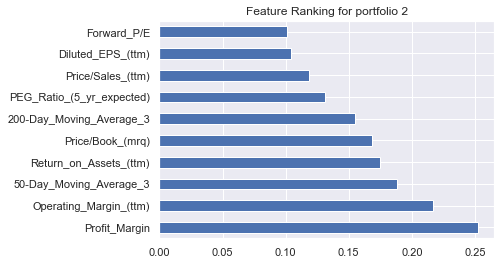

<Figure size 576x432 with 0 Axes>

In [172]:
mutual_info2.nlargest(10).plot(kind='barh')
plt.title("Feature Ranking for portfolio 2")
plt.figure(figsize=(8,6))
plt.show()

<h2>Model Building

In [575]:
columns=['Model Name', 'MeanAbsError', 'MeanSqrError', 'RootMeanSqrError', 'R2SqrError', 'CrossValScore']
modelEvalPortfolio1 = pd.DataFrame(columns=columns)
modelEvalPortfolio2 = pd.DataFrame(columns=columns)

In [577]:
# Display Matrices
def displayMetrics(y_te, y_pred, modelname, model, test_X, test_Y, X_tr, y_tr, ann=False):
    frameDict = dict()
    meanAbsError = metrics.mean_absolute_error(y_te, y_pred)
    meanSqrError = metrics.mean_squared_error(y_te, y_pred)
    rootMeanSqrError = math.sqrt(meanSqrError)   
    rSqrTest = metrics.r2_score(y_te, y_pred)
    # rSqrTrain = metrics.r2_score(y_tr, y_pred)
    print("Mean Abs Error: {:.5f}".format(meanAbsError))
    print("Mean Sqr Error: {:.5f}".format(meanSqrError))
    print("Root Mean Sqr Error: {:.5f}".format(rootMeanSqrError))
    print("R square Test: {:.5f}".format(rSqrTest))
    # print("R square Trains: {:.5f}".format(rSqrTrain))
    frameDict['Model Name']=modelname
    frameDict['MeanAbsError']=meanAbsError
    frameDict['MeanSqrError']=meanSqrError
    frameDict['RootMeanSqrError']=rootMeanSqrError
    frameDict['R2SqrError']=rSqrTest
    if ann==False:
        crossValScore =cross_val_score(model, X_tr, y_tr, scoring = 'r2',cv=5).mean()
        print(f"{modelname} Cross val score: ", crossValScore)
        print(f"{modelname} score: ", model.score(test_X, test_Y) * 100)
        frameDict['CrossValScore']=crossValScore
    else:
        frameDict['CrossValScore']=0.0

    return frameDict

def displayMetricsForANN(y_te, y_pred, modelname, model, test_X, test_Y, X_tr, y_tr):
    frameDict= dict()
    meanAbsError = metrics.mean_absolute_error(y_te, y_pred)
    meanSqrError = metrics.mean_squared_error(y_te, y_pred)
    rootMeanSqrError = math.sqrt(meanSqrError)   
    rSqrTest = metrics.r2_score(y_te, y_pred)
    # rSqrTrain = metrics.r2_score(y_tr, y_pred)
    print("Mean Abs Error: {:.5f}".format(meanAbsError))
    print("Mean Sqr Error: {:.5f}".format(meanSqrError))
    print("Root Mean Sqr Error: {:.5f}".format(rootMeanSqrError))
    print("R square Test: {:.5f}".format(rSqrTest))
    # print("R square Trains: {:.5f}".format(rSqrTrain))
    frameDict['Model Name']=modelname
    frameDict['MeanAbsError']=meanAbsError
    frameDict['MeanSqrError']=meanSqrError
    frameDict['RootMeanSqrError']=rootMeanSqrError
    frameDict['R2SqrError']=rSqrTest
    frameDict['CrossValScore']=0.0
    return frameDict

def buildAndTestModel(model, X_tr, y_tr, X_te, y_te, modelName):
    model.fit(X_tr, y_tr.reshape(-1, 1))
    # Test the model
    y_pred_test = model.predict(X_te)
    y_pred_train = model.predict(X_te)
    print(f"Test metrices from {modelName} are: \n")
    frameDict = displayMetrics(y_te, y_pred_test, modelName, model, X_te, y_te, X_tr, y_tr)
    # print("\n")
    # print(f"Train metrices from {modelName} are: \n")
    # displayMetrics(y_tr, y_pred_train, modelName, model, X_te, y_te, X_tr, y_tr)
    return y_pred_test, y_te, frameDict

<h4>Model building for Portfolio 1

In [578]:
x1_Tr=np.array(X_train1)
y1_Tr=np.array(y_train1)

x1_Te=np.array(X_test1)
y1_Te=np.array(y_test1)

<h5>Linear Regression

Test metrices from Linear Regression Portfolio 1 are: 

Mean Abs Error: 0.08702
Mean Sqr Error: 0.01348
Root Mean Sqr Error: 0.11610
R square Test: 0.40534
Linear Regression Portfolio 1 Cross val score:  -0.08208564701787868
Linear Regression Portfolio 1 score:  40.53359527545778


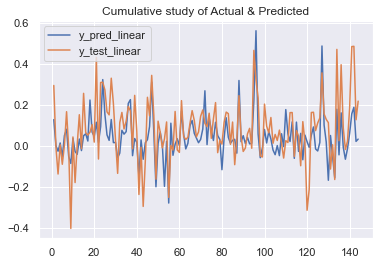

In [579]:
linearPort1 = LinearRegression()
y_pred_p1_lin, y_test_p1_lin, frameDict= buildAndTestModel(linearPort1, x1_Tr, y1_Tr, x1_Te, y1_Te, "Linear Regression Portfolio 1")
modelEvalPortfolio1 = modelEvalPortfolio1._append(frameDict, ignore_index = True)

linearPort1Dict = {'y_pred_linear': pd.DataFrame(y_pred_p1_lin), 'y_test_linear': pd.DataFrame(y_test_p1_lin)}
for k in linearPort1Dict:
    plt.plot(linearPort1Dict[k].diff().mean(axis=1).cumsum(), label=k)
    plt.title(f'Cumulative study of Actual & Predicted')
    plt.legend()

<h5>Decision Tree

Test metrices from Decision Tree Portfolio 1 are: 

Mean Abs Error: 0.10495
Mean Sqr Error: 0.01910
Root Mean Sqr Error: 0.13822
R square Test: 0.15728
Decision Tree Portfolio 1 Cross val score:  -0.31720756949493883
Decision Tree Portfolio 1 score:  15.727713470010595


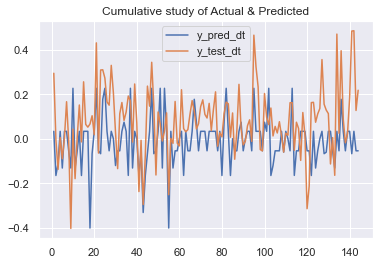

In [580]:
dtPortfolio1=DecisionTreeRegressor(max_depth=5)
y_pred_p1_dt, y_test_p1_dt, frameDict = buildAndTestModel(dtPortfolio1, x1_Tr, y1_Tr, x1_Te, y1_Te, "Decision Tree Portfolio 1")
modelEvalPortfolio1 = modelEvalPortfolio1._append(frameDict, ignore_index = True)

dtPort1Dict = {'y_pred_dt': pd.DataFrame(y_pred_p1_dt), 'y_test_dt': pd.DataFrame(y_test_p1_dt)}
for k in dtPort1Dict:
    plt.plot(dtPort1Dict[k].diff().mean(axis=1).cumsum(), label=k)
    plt.title(f'Cumulative study of Actual & Predicted')
    plt.legend()

<h5>Support Vector Machine

Test metrices from SVM Portfolio 1 are: 

Mean Abs Error: 0.10814
Mean Sqr Error: 0.02059
Root Mean Sqr Error: 0.14350
R square Test: 0.09166
SVM Portfolio 1 Cross val score:  -0.05499459454114548
SVM Portfolio 1 score:  9.165840702487571


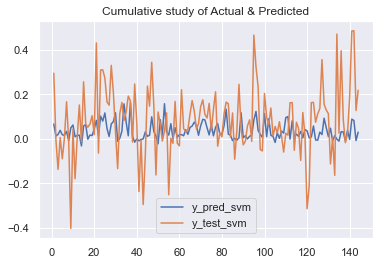

In [581]:
svmPortfolio1=SVR()
y_pred_p1_svm, y_test_p1_svm, frameDict = buildAndTestModel(svmPortfolio1, x1_Tr, y1_Tr, x1_Te, y1_Te, "SVM Portfolio 1")
modelEvalPortfolio1 = modelEvalPortfolio1._append(frameDict, ignore_index = True)

svmPort1Dict = {'y_pred_svm': pd.DataFrame(y_pred_p1_svm), 'y_test_svm': pd.DataFrame(y_test_p1_svm)}
for k in svmPort1Dict:
    plt.plot(svmPort1Dict[k].diff().mean(axis=1).cumsum(), label=k)
    plt.title(f'Cumulative study of Actual & Predicted')
    plt.legend()

<h5>Lasso Regression

Test metrices from Lasso Portfolio 1 are: 

Mean Abs Error: 0.09672
Mean Sqr Error: 0.01656
Root Mean Sqr Error: 0.12869
R square Test: 0.26941
Lasso Portfolio 1 Cross val score:  0.060471179168284726
Lasso Portfolio 1 score:  26.941131448494595


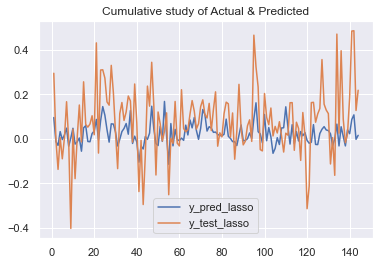

In [582]:
lassoPortfolio1=linear_model.Lasso(alpha=0.0009001, 
              precompute=True, 
              positive=True, 
              selection='random',
              random_state=42)
y_pred_p1_lasso, y_test_p1_lasso, frameDict = buildAndTestModel(lassoPortfolio1, x1_Tr, y1_Tr, x1_Te, y1_Te, "Lasso Portfolio 1")
modelEvalPortfolio1 = modelEvalPortfolio1._append(frameDict, ignore_index = True)

lassoPort1Dict = {'y_pred_lasso': pd.DataFrame(y_pred_p1_lasso), 'y_test_lasso': pd.DataFrame(y_test_p1_lasso)}
for k in lassoPort1Dict:
    plt.plot(lassoPort1Dict[k].diff().mean(axis=1).cumsum(), label=k)
    plt.title(f'Cumulative study of Actual & Predicted')
    plt.legend()

<h5>Random Forest Regressor

Test metrices from Random Forest Portfolio 1 are: 

Mean Abs Error: 0.08916
Mean Sqr Error: 0.01392
Root Mean Sqr Error: 0.11797
R square Test: 0.38608
Random Forest Portfolio 1 Cross val score:  0.23242829194051637
Random Forest Portfolio 1 score:  38.607816307104905


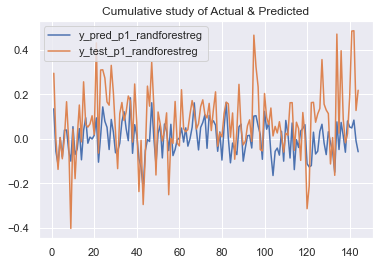

In [583]:
randforPortfolio1=RandomForestRegressor(max_depth=100)
y_pred_p1_randforestreg, y_test_p1_randforestreg, frameDict = buildAndTestModel(randforPortfolio1, x1_Tr, y1_Tr, x1_Te, y1_Te, "Random Forest Portfolio 1")
modelEvalPortfolio1 = modelEvalPortfolio1._append(frameDict, ignore_index = True)

ranforPort1Dict = {'y_pred_p1_randforestreg': pd.DataFrame(y_pred_p1_randforestreg), 'y_test_p1_randforestreg': pd.DataFrame(y_test_p1_randforestreg)}
for k in ranforPort1Dict:
    plt.plot(ranforPort1Dict[k].diff().mean(axis=1).cumsum(), label=k)
    plt.title(f'Cumulative study of Actual & Predicted')
    plt.legend()

<h5>Ridge Regression

In [584]:
ridgePortfolio1 = Ridge(alpha=10, solver='cholesky', tol=0.0000001, random_state=42)
y_pred_p1_ridge, y_test_p1_ridge, frameDict = buildAndTestModel(ridgePortfolio1, x1_Tr, y1_Tr, x1_Te, y1_Te, "Ridge Portfolio 1")
modelEvalPortfolio1 = modelEvalPortfolio1._append(frameDict, ignore_index = True)

ridgePort1Dict = {'y_pred_p1_ridge': pd.DataFrame(y_pred_p1_ridge), 'y_test_p1_ridge': pd.DataFrame(y_test_p1_ridge)}
for k in ridgePort1Dict:
    plt.plot(ridgePort1Dict[k].diff().mean(axis=1).cumsum(), label=k)
    plt.title(f'Cumulative study of Actual & Predicted')
    plt.legend()

Test metrices from Ridge Portfolio 1 are: 

Mean Abs Error: 0.10415
Mean Sqr Error: 0.01949
Root Mean Sqr Error: 0.13961
R square Test: 0.14018
Ridge Portfolio 1 Cross val score:  0.042446878360495856
Ridge Portfolio 1 score:  14.018177024501345


In [513]:
from sklearn.model_selection import GridSearchCV

In [517]:
ridgePortfolio1.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'random_state', 'solver', 'tol'])

<h5>Elastic Net

In [585]:
elasticNetPortfolio1 = ElasticNet(alpha=0.00000001, l1_ratio=0.9, selection='random', random_state=42)
y_pred_p1_elastic, y_test_p1_elastic, frameDict = buildAndTestModel(elasticNetPortfolio1, x1_Tr, y1_Tr, x1_Te, y1_Te, "Elastic Portfolio 1")
modelEvalPortfolio1 = modelEvalPortfolio1._append(frameDict, ignore_index = True)

elasticPort1Dict = {'y_pred_p1_elastic': pd.DataFrame(y_pred_p1_elastic), 'y_test_p1_elastic': pd.DataFrame(y_test_p1_elastic)}
for k in elasticPort1Dict:
    plt.plot(elasticPort1Dict[k].diff().mean(axis=1).cumsum(), label=k)
    plt.title(f'Cumulative study of Actual & Predicted')
    plt.legend()

Test metrices from Elastic Portfolio 1 are: 

Mean Abs Error: 0.08565
Mean Sqr Error: 0.01304
Root Mean Sqr Error: 0.11418
R square Test: 0.42489
Elastic Portfolio 1 Cross val score:  -0.15640260953623236
Elastic Portfolio 1 score:  42.489310127011905


<h5>Stochastic Gradient Descent

Test metrices from SGD Portfolio 1 are: 

Mean Abs Error: 0.09875
Mean Sqr Error: 0.01761
Root Mean Sqr Error: 0.13272
R square Test: 0.22299
SGD Portfolio 1 Cross val score:  0.15727986317552684
SGD Portfolio 1 score:  22.298629176876318


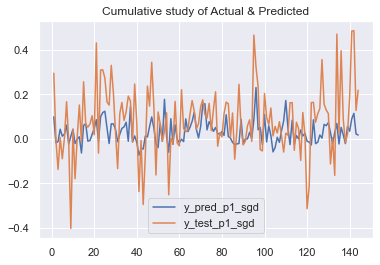

In [586]:
sgdPortfolio1 = SGDRegressor(n_iter_no_change=2500, penalty=None, eta0=0.001, max_iter=1000000000)
y_pred_p1_sgd, y_test_p1_sgd, frameDict = buildAndTestModel(sgdPortfolio1, x1_Tr, y1_Tr, x1_Te, y1_Te, "SGD Portfolio 1")
modelEvalPortfolio1 = modelEvalPortfolio1._append(frameDict, ignore_index = True)

sgdPort1Dict = {'y_pred_p1_sgd': pd.DataFrame(y_pred_p1_sgd), 'y_test_p1_sgd': pd.DataFrame(y_test_p1_sgd)}
for k in sgdPort1Dict:
    plt.plot(sgdPort1Dict[k].diff().mean(axis=1).cumsum(), label=k)
    plt.title(f'Cumulative study of Actual & Predicted')
    plt.legend()

<h5>Artficial Neural Network

In [588]:
modelP1 = Sequential()
# x1_Tr, y1_Tr
modelP1.add(Dense(x1_Tr.shape[1], activation='relu'))
modelP1.add(Dense(16, activation='relu'))
# model.add(Dropout(0.2))

modelP1.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))

modelP1.add(Dense(64, activation='relu'))

modelP1.add(Dense(128, activation='relu'))
# model.add(Dropout(0.1))
modelP1.add(Dense(1))

modelP1.compile(optimizer=Adam(0.00001), loss='mse')

r = modelP1.fit(x1_Tr, y1_Tr,
              validation_data=(x1_Te,y1_Te),
              batch_size=1,
              epochs=100)

Epoch 1/100


145/145 [==============================] - 2s 3ms/step - loss: 0.6033 - val_loss: 0.5407
Epoch 2/100
145/145 [==============================] - 1s 4ms/step - loss: 0.4784 - val_loss: 0.4305
Epoch 3/100
145/145 [==============================] - 1s 4ms/step - loss: 0.3798 - val_loss: 0.3405
Epoch 4/100
145/145 [==============================] - 1s 7ms/step - loss: 0.2985 - val_loss: 0.2638
Epoch 5/100
145/145 [==============================] - 1s 7ms/step - loss: 0.2248 - val_loss: 0.1941
Epoch 6/100
145/145 [==============================] - 1s 4ms/step - loss: 0.1605 - val_loss: 0.1348
Epoch 7/100
145/145 [==============================] - 1s 3ms/step - loss: 0.1092 - val_loss: 0.0916
Epoch 8/100
145/145 [==============================] - 1s 3ms/step - loss: 0.0742 - val_loss: 0.0657
Epoch 9/100
145/145 [==============================] - 0s 3ms/step - loss: 0.0544 - val_loss: 0.0528
Epoch 10/100
145/145 [==============================] - 0s 3ms/step - loss: 0.0447 - val_loss: 0.0472
E

In [589]:
testPredANN1 = modelP1.predict(x1_Te)
trainPredANN1 = modelP1.predict(x1_Tr)

5/5 [==============================] - 0s 2ms/step


5/5 [==============================] - 0s 3ms/step


Test metrices from ANN are: 

Mean Abs Error: 0.10463
Mean Sqr Error: 0.01961
Root Mean Sqr Error: 0.14002
R square Test: 0.13511


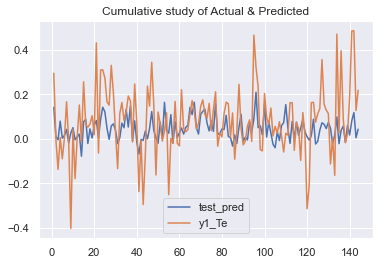

In [590]:
print(f"Test metrices from ANN are: \n")
frameDict=displayMetrics(y1_Te, testPredANN1, "Artificial Neural Network 1", model, x1_Te, y1_Te, x1_Tr, y1_Tr, ann=True)
modelEvalPortfolio1 = modelEvalPortfolio1._append(frameDict, ignore_index = True)

annPort1Dict = {'test_pred': pd.DataFrame(test_pred), 'y1_Te': pd.DataFrame(y1_Te)}
for k in annPort1Dict:
    plt.plot(annPort1Dict[k].diff().mean(axis=1).cumsum(), label=k)
    plt.title(f'Cumulative study of Actual & Predicted')
    plt.legend()

<h4>Model Comparisons

In [591]:
modelEvalPortfolio1

Model Name  MeanAbsError  MeanSqrError  \
0  Linear Regression Portfolio 1      0.087021      0.013480   
1      Decision Tree Portfolio 1      0.104947      0.019103   
2                SVM Portfolio 1      0.108136      0.020591   
3              Lasso Portfolio 1      0.096717      0.016561   
4      Random Forest Portfolio 1      0.089165      0.013917   
5              Ridge Portfolio 1      0.104154      0.019491   
6            Elastic Portfolio 1      0.085653      0.013037   
7                SGD Portfolio 1      0.098748      0.017614   
8    Artificial Neural Network 1      0.104628      0.019606   

   RootMeanSqrError  R2SqrError  CrossValScore  
0          0.116105    0.405336      -0.082086  
1          0.138215    0.157277      -0.317208  
2          0.143495    0.091658      -0.054995  
3          0.128691    0.269411       0.060471  
4          0.117970    0.386078       0.232428  
5          0.139610    0.140182       0.042447  
6          0.114179    0.424893      -0.156403  
7          0.132717    0.222986       0.157280  
8          0.140021    0.135112       0.000000

In [592]:
modelEvalPortfolio1.set_index('Model Name', inplace=True)

<AxesSubplot:ylabel='Model Name'>

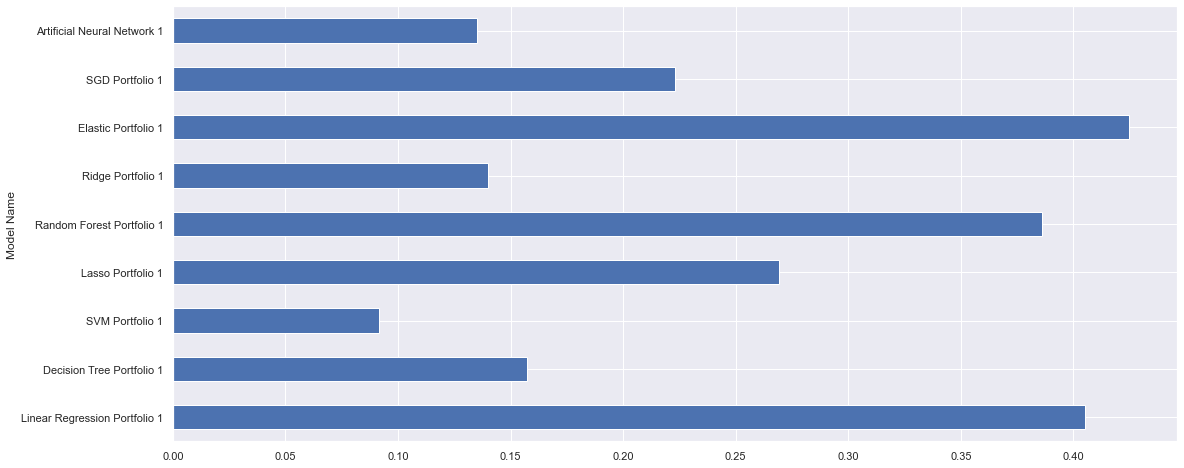

In [593]:
modelEvalPortfolio1['R2SqrError'].plot(kind='barh', figsize=(18, 8))

<h4>Model building for Portfolio 2

In [594]:
x2_Tr=np.array(X_train2)
y2_Tr=np.array(y_train2)

x2_Te=np.array(X_test2)
y2_Te=np.array(y_test2)

<h5>Linear Regression

Test metrices from Linear Regression Portfolio 2 are: 

Mean Abs Error: 0.10389
Mean Sqr Error: 0.03324
Root Mean Sqr Error: 0.18231
R square Test: -1.37243
Linear Regression Portfolio 2 Cross val score:  -0.19004195398743523
Linear Regression Portfolio 2 score:  -137.2429485380993


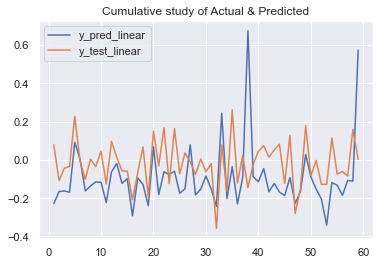

In [595]:
linearPort2 = LinearRegression()
y_pred_p2_lin, y_test_p2_lin, frameDict= buildAndTestModel(linearPort2, x2_Tr, y2_Tr, x2_Te, y2_Te, "Linear Regression Portfolio 2")
modelEvalPortfolio2 = modelEvalPortfolio2._append(frameDict, ignore_index = True)

linearPort2Dict = {'y_pred_linear': pd.DataFrame(y_pred_p2_lin), 'y_test_linear': pd.DataFrame(y_test_p2_lin)}
for k in linearPort2Dict:
    plt.plot(linearPort2Dict[k].diff().mean(axis=1).cumsum(), label=k)
    plt.title(f'Cumulative study of Actual & Predicted')
    plt.legend()

<h5>Decision Tree

Test metrices from Decision Tree Portfolio 2 are: 

Mean Abs Error: 0.10501
Mean Sqr Error: 0.02342
Root Mean Sqr Error: 0.15303
R square Test: -0.67158
Decision Tree Portfolio 2 Cross val score:  -0.0835396818471456
Decision Tree Portfolio 2 score:  -67.15830600305235


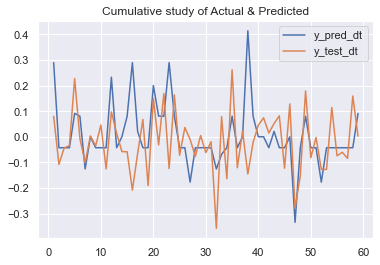

In [596]:
dtPortfolio2=DecisionTreeRegressor(max_depth=5)
y_pred_p2_dt, y_test_p2_dt, frameDict = buildAndTestModel(dtPortfolio2, x2_Tr, y2_Tr, x2_Te, y2_Te, "Decision Tree Portfolio 2")
modelEvalPortfolio2 = modelEvalPortfolio2._append(frameDict, ignore_index = True)

dtPort2Dict = {'y_pred_dt': pd.DataFrame(y_pred_p2_dt), 'y_test_dt': pd.DataFrame(y_test_p2_dt)}
for k in dtPort2Dict:
    plt.plot(dtPort2Dict[k].diff().mean(axis=1).cumsum(), label=k)
    plt.title(f'Cumulative study of Actual & Predicted')
    plt.legend()

<h5>Support Vector Machine

Test metrices from SVM Portfolio 2 are: 

Mean Abs Error: 0.08761
Mean Sqr Error: 0.01114
Root Mean Sqr Error: 0.10557
R square Test: 0.20454
SVM Portfolio 2 Cross val score:  0.2464410499032398
SVM Portfolio 2 score:  20.453677643205502


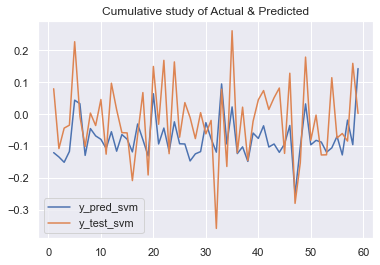

In [597]:
svmPortfolio2=SVR()
y_pred_p2_svm, y_test_p2_svm, frameDict = buildAndTestModel(svmPortfolio2, x2_Tr, y2_Tr, x2_Te, y2_Te, "SVM Portfolio 2")
modelEvalPortfolio2 = modelEvalPortfolio2._append(frameDict, ignore_index = True)

svmPort2Dict = {'y_pred_svm': pd.DataFrame(y_pred_p2_svm), 'y_test_svm': pd.DataFrame(y_test_p2_svm)}
for k in svmPort2Dict:
    plt.plot(svmPort2Dict[k].diff().mean(axis=1).cumsum(), label=k)
    plt.title(f'Cumulative study of Actual & Predicted')
    plt.legend()

<h5>Lasso Regression

Test metrices from Lasso Portfolio 2 are: 

Mean Abs Error: 0.09292
Mean Sqr Error: 0.01642
Root Mean Sqr Error: 0.12815
R square Test: -0.17222
Lasso Portfolio 2 Cross val score:  0.30571761349356025
Lasso Portfolio 2 score:  -17.222448524943967


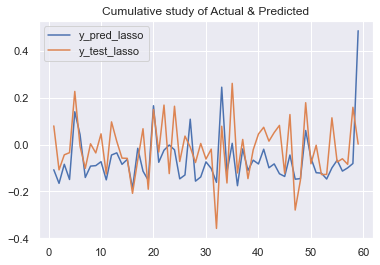

In [598]:
lassoPortfolio2=linear_model.Lasso(alpha=0.000001, 
              precompute=True, 
              positive=True, 
              selection='random',
              random_state=42)
y_pred_p2_lasso, y_test_p2_lasso, frameDict = buildAndTestModel(lassoPortfolio2, x2_Tr, y2_Tr, x2_Te, y2_Te, "Lasso Portfolio 2")
modelEvalPortfolio2 = modelEvalPortfolio2._append(frameDict, ignore_index = True)

lassoPort2Dict = {'y_pred_lasso': pd.DataFrame(y_pred_p2_lasso), 'y_test_lasso': pd.DataFrame(y_test_p2_lasso)}
for k in lassoPort2Dict:
    plt.plot(lassoPort2Dict[k].diff().mean(axis=1).cumsum(), label=k)
    plt.title(f'Cumulative study of Actual & Predicted')
    plt.legend()

<h5>Random Forest Regressor

Test metrices from Random Forest Portfolio 2 are: 

Mean Abs Error: 0.07835
Mean Sqr Error: 0.01091
Root Mean Sqr Error: 0.10445
R square Test: 0.22133
Random Forest Portfolio 2 Cross val score:  0.30292680208737194
Random Forest Portfolio 2 score:  22.13281134673669


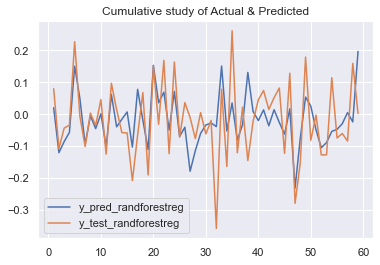

In [599]:
randforPortfolio2=RandomForestRegressor(max_depth=100)
y_pred_p2_randforestreg, y_test_p2_randforestreg, frameDict = buildAndTestModel(randforPortfolio2, x2_Tr, y2_Tr.reshape(-1, 1), x2_Te, y2_Te, "Random Forest Portfolio 2")
modelEvalPortfolio2 = modelEvalPortfolio2._append(frameDict, ignore_index = True)

ranforPort2Dict = {'y_pred_randforestreg': pd.DataFrame(y_pred_p2_randforestreg), 'y_test_randforestreg': pd.DataFrame(y_test_p2_randforestreg)}
for k in ranforPort2Dict:
    plt.plot(ranforPort2Dict[k].diff().mean(axis=1).cumsum(), label=k)
    plt.title(f'Cumulative study of Actual & Predicted')
    plt.legend()

<h5>Ridge Regression

In [600]:
ridgePortfolio2 = Ridge(alpha=10, solver='cholesky', tol=0.1, random_state=42)
y_pred_p2_ridge, y_test_p2_ridge, frameDict = buildAndTestModel(ridgePortfolio2, x2_Tr, y2_Tr, x2_Te, y2_Te, "Ridge Portfolio 2")
modelEvalPortfolio2 = modelEvalPortfolio2._append(frameDict, ignore_index = True)

ridgePort2Dict = {'y_pred_ridge': pd.DataFrame(y_pred_p2_ridge), 'y_test_ridge': pd.DataFrame(y_test_p2_ridge)}
for k in ridgePort2Dict:
    plt.plot(ridgePort2Dict[k].diff().mean(axis=1).cumsum(), label=k)
    plt.title(f'Cumulative study of Actual & Predicted')
    plt.legend()

Test metrices from Ridge Portfolio 2 are: 

Mean Abs Error: 0.08983
Mean Sqr Error: 0.01205
Root Mean Sqr Error: 0.10979
R square Test: 0.13961
Ridge Portfolio 2 Cross val score:  0.18668605427154622
Ridge Portfolio 2 score:  13.960825585850401


<h5>Elastic Net

In [601]:
elasticNetPortfolio2 = ElasticNet(alpha=0.001, l1_ratio=0.2, selection='random', random_state=42)
y_pred_p2_elastic, y_test_p2_elastic, frameDict = buildAndTestModel(elasticNetPortfolio2, x2_Tr, y2_Tr, x2_Te, y2_Te, "Elastic Portfolio 2")
modelEvalPortfolio2 = modelEvalPortfolio2._append(frameDict, ignore_index = True)

elasticPort2Dict = {'y_pred_elastic': pd.DataFrame(y_pred_p2_elastic), 'y_test_elastic': pd.DataFrame(y_test_p2_elastic)}
for k in elasticPort2Dict:
    plt.plot(elasticPort2Dict[k].diff().mean(axis=1).cumsum(), label=k)
    plt.title(f'Cumulative study of Actual & Predicted')
    plt.legend()

Test metrices from Elastic Portfolio 2 are: 

Mean Abs Error: 0.08573
Mean Sqr Error: 0.01340
Root Mean Sqr Error: 0.11577
R square Test: 0.04333
Elastic Portfolio 2 Cross val score:  0.34137326768919574
Elastic Portfolio 2 score:  4.333165851144294


<h5>Stochastic Gradient Descent

In [602]:
sgdPortfolio2 = SGDRegressor(n_iter_no_change=25000, penalty=None, eta0=0.001, max_iter=1000000000)
y_pred_p2_sgd, y_test_p2_sgd, frameDict = buildAndTestModel(sgdPortfolio2, x2_Tr, y2_Tr, x2_Te, y2_Te, "SGD Portfolio 2")
modelEvalPortfolio2 = modelEvalPortfolio2._append(frameDict, ignore_index = True)

sgdPort2Dict = {'y_pred_sgd': pd.DataFrame(y_pred_p2_sgd), 'y_test_sgd': pd.DataFrame(y_test_p2_sgd)}
for k in sgdPort2Dict:
    plt.plot(sgdPort2Dict[k].diff().mean(axis=1).cumsum(), label=k)
    plt.title(f'Cumulative study of Actual & Predicted')
    plt.legend()

Test metrices from SGD Portfolio 2 are: 

Mean Abs Error: 0.08270
Mean Sqr Error: 0.01255
Root Mean Sqr Error: 0.11205
R square Test: 0.10392
SGD Portfolio 2 Cross val score:  0.35792299802199723
SGD Portfolio 2 score:  10.39166343093757


<h5>Artficial Neural Network

In [603]:
modelP2 = Sequential()

modelP2.add(Dense(x1_Tr.shape[1], activation='relu'))
modelP2.add(Dense(32, activation='relu'))
modelP2.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))

modelP2.add(Dense(128, activation='relu'))

modelP2.add(Dense(512, activation='relu'))
# model.add(Dropout(0.1))
modelP2.add(Dense(1))

modelP2.compile(optimizer=Adam(0.00001), loss='mse')

r = modelP2.fit(x1_Tr, y1_Tr,
              validation_data=(x1_Te,y1_Te),
              batch_size=1,
              epochs=100)

Epoch 1/100


145/145 [==============================] - 3s 8ms/step - loss: 0.2881 - val_loss: 0.1385
Epoch 2/100
145/145 [==============================] - 1s 4ms/step - loss: 0.0862 - val_loss: 0.0595
Epoch 3/100
145/145 [==============================] - 1s 4ms/step - loss: 0.0518 - val_loss: 0.0516
Epoch 4/100
145/145 [==============================] - 1s 5ms/step - loss: 0.0475 - val_loss: 0.0492
Epoch 5/100
145/145 [==============================] - 1s 4ms/step - loss: 0.0447 - val_loss: 0.0473
Epoch 6/100
145/145 [==============================] - 1s 4ms/step - loss: 0.0428 - val_loss: 0.0445
Epoch 7/100
145/145 [==============================] - 1s 5ms/step - loss: 0.0398 - val_loss: 0.0425
Epoch 8/100
145/145 [==============================] - 1s 4ms/step - loss: 0.0381 - val_loss: 0.0401
Epoch 9/100
145/145 [==============================] - 1s 4ms/step - loss: 0.0356 - val_loss: 0.0378
Epoch 10/100
145/145 [==============================] - 1s 4ms/step - loss: 0.0331 - val_loss: 0.0359
E

In [604]:
testPredANN2 = modelP2.predict(x1_Te)
trainPredANN2 = modelP2.predict(x1_Tr)

5/5 [==============================] - 0s 1ms/step


5/5 [==============================] - 0s 3ms/step


In [605]:
print(f"Test metrices from ANN are: \n")
frameDict=displayMetrics(y1_Te, test_pred, "Artificial Neural Network", modelP2, x1_Te, y1_Te, x1_Tr, y1_Tr, ann=True)
modelEvalPortfolio2 = modelEvalPortfolio2._append(frameDict, ignore_index = True)

annPort2Dict = {'test_pred': pd.DataFrame(testPredANN2), 'train_pred': pd.DataFrame(trainPredANN2)}
for k in annPort2Dict:
    plt.plot(annPort2Dict[k].diff().mean(axis=1).cumsum(), label=k)
    plt.title(f'Cumulative study of Actual & Predicted')
    plt.legend()

Test metrices from ANN are: 

Mean Abs Error: 0.10104
Mean Sqr Error: 0.01799
Root Mean Sqr Error: 0.13412
R square Test: 0.20648


<h4>Model Comparisons

In [606]:
modelEvalPortfolio2

Model Name  MeanAbsError  MeanSqrError  \
0  Linear Regression Portfolio 2      0.103887      0.033238   
1      Decision Tree Portfolio 2      0.105012      0.023419   
2                SVM Portfolio 2      0.087615      0.011145   
3              Lasso Portfolio 2      0.092918      0.016423   
4      Random Forest Portfolio 2      0.078347      0.010909   
5              Ridge Portfolio 2      0.089827      0.012054   
6            Elastic Portfolio 2      0.085726      0.013403   
7                SGD Portfolio 2      0.082702      0.012554   
8      Artificial Neural Network      0.101041      0.017988   

   RootMeanSqrError  R2SqrError  CrossValScore  
0          0.182313   -1.372429      -0.190042  
1          0.153033   -0.671583      -0.083540  
2          0.105568    0.204537       0.246441  
3          0.128153   -0.172224       0.305718  
4          0.104448    0.221328       0.302927  
5          0.109792    0.139608       0.186686  
6          0.115772    0.043332       0.341373  
7          0.112046    0.103917       0.357923  
8          0.134119    0.206483       0.000000

In [607]:
modelEvalPortfolio2.set_index('Model Name', inplace=True)

In [608]:
modelEvalPortfolio2['R2SqrError'].plot(kind='barh', figsize=(18, 8))

<AxesSubplot:ylabel='Model Name'>